##  TODO:
- update the README, (starting from logbookreader probably)
- separate IME and USTC analysis
    - downside, I might want to change things in both
    - maybe I need to make shared functions to analyze/plot

In [7]:
from importlib import reload # to reload modules
import numpy as np # NumPy
import matplotlib.pylab as plt # Matplotlib plots
import matplotlib.patches as mpatches
from matplotlib import colormaps # colormaps
from matplotlib.colors import hsv_to_rgb
from matplotlib.legend_handler import HandlerLine2D

import pandas as pd # Pandas
import uproot
import pickle
import logging
import pprint
from adjustText import adjust_text

import os # read directories etc.
from scipy.optimize import curve_fit
import pylandau

# import time
# from timeout_decorator import timeout

import LoadBatch
reload(LoadBatch)
from LoadBatch import *
from SensorClasses import *

verbose = False

In [8]:
# logging.basicConfig(level=logging.WARNING, format='[%(levelname)s] -\t %(message)s')
logging.basicConfig(level=logging.INFO, format='[%(levelname)s] - \t %(message)s')

In [9]:
# PIXEL_SIZE = 0.0184 #mm

### choose the bins so that they match the MIMOSA pixels (which are just the coordinates)
### I should just have many options for ranges and choose between those
large_bins = (np.arange(0, 900,1),
              np.arange(0, 600,1))

bins1 = (np.arange(450, 700, 1),
        np.arange(100, 500, 1))

bins2 = (np.arange(350, 700, 1),
              np.arange(100, 500, 1))

bins3 = (np.arange(300, 800, 1),
              np.arange(0, 450, 1))

bins4 = (np.arange(500, 800, 1),
              np.arange(100, 500, 1))

### Load the dictionary of sensor names and runs
# dict_of_runs = read_pickle("dict_of_runs.pickle")
dict_of_batches = read_pickle("dict_of_batches.pickle")

# logging.info(f"dictionary of the runs: \n{dict_of_runs.keys()}")
logging.info(f"dictionary of the batches: \n{dict_of_batches.keys()}")

### branches to be loaded (+ unnecessary columns)
branches = ["eventNumber", "Xtr", "Ytr", "pulseHeight", "charge", "noise", "timeCFD20", "timeCFD50", "timeCFD70"]
columns_to_remove = ["Xtr_4","Xtr_5","Xtr_6","Xtr_7","Ytr_4","Ytr_5","Ytr_6","Ytr_7"]

### charge fit folder
charge_fit_dir = "/home/marcello/Desktop/Radboud_not_synchro/Master_Thesis/testbeam-analysis/ROOT Langaus fit/Charge_fit_results"

### presentation path
pres_path = '/home/marcello/Desktop/Radboud_not_synchro/Master_Thesis/Presentations/2024-01-25'

[INFO] - 	 dictionary of the batches: 
dict_keys([199, 100, 101, 201, 202, 203, 301, 401, 402, 403, 204, 406, 407, 408, 409, 410, 411, 412, 205, 206, 413, 414, 501, 502, 503, 504, 505, 601, 602, 603, 604, 605, 701, 702, 801, 802, 901, 902, 1001, 1002, 1101, 1102, 1201, 1202, 1301, 1302, 1303, 1304, 1305, 1306, 503.1, 503.2])


In [10]:
#  already run: charge:
bins_dict = {
    100:bins3, # x x
    101:bins3, # x x
    199:bins3, # x x
    201:bins1, # x x
    202:bins1, # x x
    203:bins1, # x x
    204:bins1, # x x   # weird time resolution
    205:bins4, # x x
    206:bins4, # x x
    301:bins1, # x x
    401:bins1, # x x
    402:bins1, # x x
    403:bins1, # x x
    407:bins1, # x x
    408:bins1, # x x
    409:bins1, # x x
    410:bins1, # x x
    411:bins1, # x x    sensor Ch2 in S1 probably outside area of interest
    413:bins1, # x x
    414:bins1, # x x
    501:bins2, # x x   (in all 5xx, S1 and S2: use=time in the geometry_mask) sensor Ch2 in S1 seems weird
    502:bins2, # x x
    503:bins2, # x x   sensors moved during the diffent runs (because the temperature changed, OR I EXCLUDE THEM AND STUDY THEM SEPARATELY)
    504:bins2, # x x   sensor ch4 in S1 is very irradiated and seems to have negative pulseHeight BG noise
    505:bins2, # x x   sensor Ch4 in S1 seems dead, sensor Ch2 ins S2 
    601:bins4, # x x   in all 6xx, Ch2 in S2 seem to be cut out (use=time)  Ch4 in S2 seems dead or outside area
    602:bins4, # x x   (S1: use=pulseheight,   S2: use=time)
    603:bins4, # x x   (S1: use=pulseheight,   S2: use=time)
    604:bins4, # x x   (S1: use=pulseheight,   S2: use=time)
    605:bins4, # x x   (S1: use=pulseheight,   S2: use=time)
    701:bins1, # x x
    702:bins1, # x x
    801:bins1, # x x
    802:bins1, # x x
    901:bins1, # x x  (S1: use=time)  sensor Ch3 in S1 is outside the FEi4 area (or dead)
    902:bins1, # x x  (S1: use=time)
    1001:bins2, # x x  (S1 and S2 use=time)
    1002:bins2, # x x  sensor ch4 in S2 seems dead
    1101:bins2, # x x  sensor ch3 in S2 seems weird
    1102:bins2, # x x  sensor ch2 and ch3 are outside the area
    1201:bins2, # x x  sensor ch3 in S1 is missing the name (should be 'CNM W5')
    1202:bins2, # x x
}

In [12]:
unique_names = []
for batch_object in dict_of_batches.values():
    for S in ['S1','S2']:
        for ch, sensor in batch_object.S[S].channels.items():
            if (sensor.name != '') and (sensor.name not in unique_names):
                unique_names.append(sensor.name)
logging.info(f"{unique_names}")

for name in unique_names:
    for batch_object in dict_of_batches.values():
        for S in ['S1','S2']:  
                for ch, sensor in batch_object.S[S].channels.items():
                    if (sensor.name == name):
                        if (sensor.voltage == 0) or (sensor.voltage is None): continue 
                        print(f"{sensor.name}, board: {sensor.board}\tV: {sensor.voltage}, angle: {batch_object.angle}°,", "temp: %.2f°C,"%batch_object.temperature, f"fluence: {sensor.fluence}, in batch {batch_object.batch_number}, {S}, {ch})")
    print('-'*100)

[INFO] - 	 ['MCP', 'IMEv3-W12-C2-2-2', 'IMEv3-W12-C3-1-4', 'CNM-R15973-W5-D138', 'CNM-R15973-W4-D168', 'IMEv3-W12-C3-1-5', 'USTC2.1-W17-P6-A', 'no_board', 'JSI-PP4-IMEv2-W7-6.5E14', 'JSI-B7-IMEv3-W16-8E14', 'JSI-B13-IMEv3-W16-2.5E15', 'JSI-B6-IMEv2-W7-1E14', 'JSI-PP1', 'CERN2-CH0-IMEv3-W12', 'CERN2-CH1-IMEv3-W12', 'CERN2-CH2-IMEv3-W12', 'JSI-B5-CNM-W3-2.5E15', 'CERN2-CH4-IMEv3-W16']


MCP, board: no_board	V: 2600, angle: 0.0°, temp: -31.17°C, fluence: 0, in batch 199, S1, Ch1)
MCP, board: no_board	V: 2600, angle: 0.0°, temp: -31.17°C, fluence: 0, in batch 199, S2, Ch1)
MCP, board: no_board	V: 2500, angle: 0.0°, temp: -32.87°C, fluence: 0, in batch 100, S1, Ch1)
MCP, board: no_board	V: 2500, angle: 0.0°, temp: -32.87°C, fluence: 0, in batch 100, S2, Ch1)
MCP, board: no_board	V: 2500, angle: 0.0°, temp: -33.45°C, fluence: 0, in batch 101, S1, Ch1)
MCP, board: no_board	V: 2500, angle: 0.0°, temp: -33.45°C, fluence: 0, in batch 101, S2, Ch1)
MCP, board: no_board	V: 2500, angle: 0.0°, temp: -31.75°C, fluence: 0, in batch 201, S1, Ch1)
MCP, board: no_board	V: 2500, angle: 0.0°, temp: -31.75°C, fluence: 0, in batch 201, S2, Ch1)
MCP, board: no_board	V: 2500, angle: 0.0°, temp: -32.45°C, fluence: 0, in batch 202, S1, Ch1)
MCP, board: no_board	V: 2500, angle: 0.0°, temp: -32.45°C, fluence: 0, in batch 202, S2, Ch1)
MCP, board: no_board	V: 2500, angle: 0.0°, temp: -32.58°C, f

In [6]:
unique_names

['MCP',
 'IMEv3-W12-C2-2-2',
 'IMEv3-W12-C3-1-4',
 'CNM-R15973-W5-D138',
 'CNM-R15973-W4-D168',
 'IMEv3-W12-C3-1-5',
 'USTC2.1-W17-P6-A',
 'JSI-PP4-IMEv2-W7-6.5E14',
 'JSI-B7-IMEv3-W16-8E14',
 'JSI-B13-IMEv3-W16-2.5E15',
 'JSI-B6-IMEv2-W7-1E14',
 'JSI-PP1',
 'CERN2-CH0-IMEv3-W12',
 'CERN2-CH1-IMEv3-W12',
 'CERN2-CH2-IMEv3-W12',
 'JSI-B5-CNM-W3-2.5E15',
 'CERN2-CH4-IMEv3-W16']

# USTC
looking specifically at one sensor

In [13]:
USTC_list = []
USTC_dict = {'room_temp':[], 'angled':[], 'normal':[]}
this_sensor = 'USTC'
### maybe I can make all this weird iterations into a function
for batch_object in dict_of_batches.values():
    for S in ['S1','S2']:
        for ch, sensor in batch_object.S[S].channels.items():
            if this_sensor in sensor.name:
                if batch_object.S[S].get_sensor(ch).voltage==0:
                    continue
                if batch_object.batch_number == 411:  ### in batch 411 the sensors are "cut out"
                    continue
                USTC_list.append((batch_object.batch_number, S, ch))
                if batch_object.temperature<0 and batch_object.S[S].get_sensor('Ch1').voltage==2500 and batch_object.angle==0:
                    USTC_dict['normal'].append((batch_object.batch_number, S, ch))                
                if batch_object.temperature>0:# and batch_object.S[S].get_sensor('Ch1').voltage==2500:
                    USTC_dict['room_temp'].append((batch_object.batch_number, S, ch))
                if batch_object.angle>0:
                    USTC_dict['angled'].append((batch_object.batch_number, S, ch))

### I add the zero angles with same voltages in the 'angled' 403,406,407
### I changed my mind, it makes more sense if I can plot them individually,
### so I can distinguish them when I plot them together with the rest of the data

# batches,S,chs = zip(*USTC_list)
# for idx, batch in enumerate(batches):
#     if batch in (403,406,407):
#         USTC_dict['angled'].append((batches[idx],S[idx],chs[idx]))  

logging.info(f"{USTC_list}")

[INFO] - 	 [(301, 'S1', 'Ch2'), (301, 'S1', 'Ch3'), (401, 'S1', 'Ch2'), (401, 'S1', 'Ch3'), (402, 'S1', 'Ch2'), (402, 'S1', 'Ch3'), (403, 'S1', 'Ch2'), (403, 'S1', 'Ch3'), (406, 'S1', 'Ch2'), (406, 'S1', 'Ch3'), (407, 'S1', 'Ch2'), (407, 'S1', 'Ch3'), (408, 'S1', 'Ch2'), (408, 'S1', 'Ch3'), (409, 'S1', 'Ch2'), (409, 'S1', 'Ch3'), (410, 'S1', 'Ch2'), (410, 'S1', 'Ch3'), (413, 'S1', 'Ch2'), (413, 'S1', 'Ch3'), (414, 'S1', 'Ch2'), (414, 'S1', 'Ch3')]


In [97]:
for name in unique_names:
    if this_sensor in name:
        print(name)

USTC2.1-W17-P6-A


In [98]:
print(USTC_dict['room_temp'])
print(USTC_dict['normal'])
print(USTC_dict['angled']) # + 403,406,407

[(301, 'S1', 'Ch2'), (301, 'S1', 'Ch3'), (408, 'S1', 'Ch2'), (408, 'S1', 'Ch3'), (409, 'S1', 'Ch2'), (409, 'S1', 'Ch3'), (410, 'S1', 'Ch2'), (410, 'S1', 'Ch3')]
[(401, 'S1', 'Ch2'), (401, 'S1', 'Ch3'), (402, 'S1', 'Ch2'), (402, 'S1', 'Ch3'), (403, 'S1', 'Ch2'), (403, 'S1', 'Ch3'), (407, 'S1', 'Ch2'), (407, 'S1', 'Ch3')]
[(413, 'S1', 'Ch2'), (413, 'S1', 'Ch3'), (414, 'S1', 'Ch2'), (414, 'S1', 'Ch3')]


### Create an emtpy dataframe and later add values extracted that I want
added value that it's easier to extract batch number, oscilloscope and channel without repetition

#### Create empty dictionary to store the dataframes
and folder to save all of the plots

In [111]:
key_to_study = 'room_temp'
# key_to_study = 'normal'
# key_to_study = 'angled'
print("studying:", key_to_study)

batches_to_study = USTC_dict[key_to_study]

threshold_charge = 4 #fC

save_path = f'../various plots/{this_sensor}/{key_to_study}/'
if not os.path.isdir(save_path):
    os.mkdir(save_path)

### I should save the dictionary and just reopen it to add the other data
USTC_file_name = os.path.join(f"../various plots/{this_sensor}","USTC_analysis_dict.pickle")
columns_df = ['name', 'board', 'voltage', 'MCP_voltage', 'temperature', 'angle', 'fluence', 'charge', 'charge_error', 'efficiency', 'time_resolution', 'comments', 'exclude']

print("TOTAL COLUMNS NUMBER:",len(columns_df))
### open file to read dictionary, if it doesn't exist make a new one
try:
    dict_analysis_USTC = read_pickle(USTC_file_name)
    df_analysis = dict_analysis_USTC[key_to_study]
    multi_index = df_analysis.index
except FileNotFoundError:
    logging.warning("file does not exist, creating new empty dictionary to store dataframes")
    dict_analysis_USTC = {}
    multi_index = pd.MultiIndex.from_tuples(batches_to_study, names=['batch', 'oscilloscope', 'channel'])
    df_analysis = pd.DataFrame(index=multi_index, columns=columns_df)
except KeyError:
    logging.warning(f"{key_to_study} not studied yet, create empty dataframe")
    multi_index = pd.MultiIndex.from_tuples(batches_to_study, names=['batch', 'oscilloscope', 'channel'])
    df_analysis = pd.DataFrame(index=multi_index, columns=columns_df)

### new dataframe, to erase the old one (if I change columns for example)
MAKE_NEW_DF = True
if MAKE_NEW_DF:
    logging.warning("Creating empty dataframe anyways")  # only for the single key_to_study
    multi_index = pd.MultiIndex.from_tuples(batches_to_study, names=['batch', 'oscilloscope', 'channel'])
    df_analysis = pd.DataFrame(index=multi_index, columns=columns_df)

    
idx=pd.IndexSlice

[WARNING] - 	 Creating empty dataframe anyways


studying: room_temp
TOTAL COLUMNS NUMBER: 13


In [112]:
### apparently all the runs from 412 are empty, and for some reason I have to remove the unused level
    ### yes, but I removed them from the list of batches
    

## Calculating data

[INFO] - 	 Loading batch 301 	 Oscilloscope S1


MCP: 2500 V, angle: 0.0° temperature:21.733333333333334°C
channels: Index(['Ch2', 'Ch3'], dtype='object', name='channel')
Batch:301, Scope:S1, Channel:Ch2


[INFO] - 	 in 'time_mask()': Fit parameters [ 7.35221476e+03 -5.87974101e+03  7.30029992e+01  1.76769454e+00]
[INFO] - 	 in 'time_mask()': Fit parameters [ 7.26820636e+03 -5.87949341e+03  7.24383667e+01  4.10977792e-01]


72.4383667326116 36.52
Batch:301, Scope:S1, Channel:Ch3


[INFO] - 	 in 'time_mask()': Fit parameters [ 6.50368366e+03 -5.91187363e+03  6.78637219e+01  1.36664222e+00]
[INFO] - 	 in 'time_mask()': Fit parameters [ 6.37735670e+03 -5.91171582e+03  6.72935159e+01  4.69451866e-01]
[INFO] - 	 Loading batch 408 	 Oscilloscope S1


67.2935159121046 36.52
MCP: 2500 V, angle: 0.0° temperature:21.366666666666664°C
channels: Index(['Ch2', 'Ch3'], dtype='object', name='channel')
Batch:408, Scope:S1, Channel:Ch2


[INFO] - 	 in 'time_mask()': Fit parameters [ 3.45973921e+03 -5.86424037e+03  6.70855765e+01  8.22028734e-01]
[INFO] - 	 in 'time_mask()': Fit parameters [ 3.37267049e+03 -5.86414833e+03  6.67043968e+01  1.98071738e-01]


66.70439675240007 36.52
Batch:408, Scope:S1, Channel:Ch3


[INFO] - 	 in 'time_mask()': Fit parameters [ 3.12148684e+03 -5.89865219e+03  6.42262790e+01  7.35814711e-01]
[INFO] - 	 in 'time_mask()': Fit parameters [ 3.04375607e+03 -5.89850344e+03  6.37462461e+01  2.30622212e-01]
[INFO] - 	 Loading batch 409 	 Oscilloscope S1


63.74624612958241 36.52
MCP: 2500 V, angle: 0.0° temperature:21.666666666666668°C
channels: Index(['Ch2', 'Ch3'], dtype='object', name='channel')
Batch:409, Scope:S1, Channel:Ch2


[INFO] - 	 in 'time_mask()': Fit parameters [ 3.94651137e+03 -5.86465570e+03  6.17771231e+01  9.69492225e-01]
[INFO] - 	 in 'time_mask()': Fit parameters [ 3.88180243e+03 -5.86455273e+03  6.14122912e+01  3.05922430e-01]


61.41229124022277 36.52
Batch:409, Scope:S1, Channel:Ch3


[INFO] - 	 in 'time_mask()': Fit parameters [ 3.45391421e+03 -5.89683889e+03  5.92156934e+01  6.97307313e-01]
[INFO] - 	 in 'time_mask()': Fit parameters [ 3.20132380e+03 -5.89685391e+03  5.88687676e+01  2.84045886e-01]
[INFO] - 	 Loading batch 410 	 Oscilloscope S1


58.86876762251215 36.52
MCP: 2600 V, angle: 0.0° temperature:21.7°C
channels: Index(['Ch2', 'Ch3'], dtype='object', name='channel')
Batch:410, Scope:S1, Channel:Ch2


[INFO] - 	 in 'time_mask()': Fit parameters [ 3.03128969e+03 -5.85852149e+03  4.65832868e+01  5.82337982e-01]
[INFO] - 	 in 'time_mask()': Fit parameters [ 2.76648517e+03 -5.85851260e+03  4.63617903e+01  1.58985722e-01]


46.361790298573425 16.48
Batch:410, Scope:S1, Channel:Ch3


[INFO] - 	 in 'time_mask()': Fit parameters [ 2.68316025e+03 -5.88991571e+03  4.44007555e+01  4.52542882e-01]
[INFO] - 	 in 'time_mask()': Fit parameters [ 2.51722439e+03 -5.88990764e+03  4.41716105e+01  1.58862443e-01]


44.171610451971006 16.48


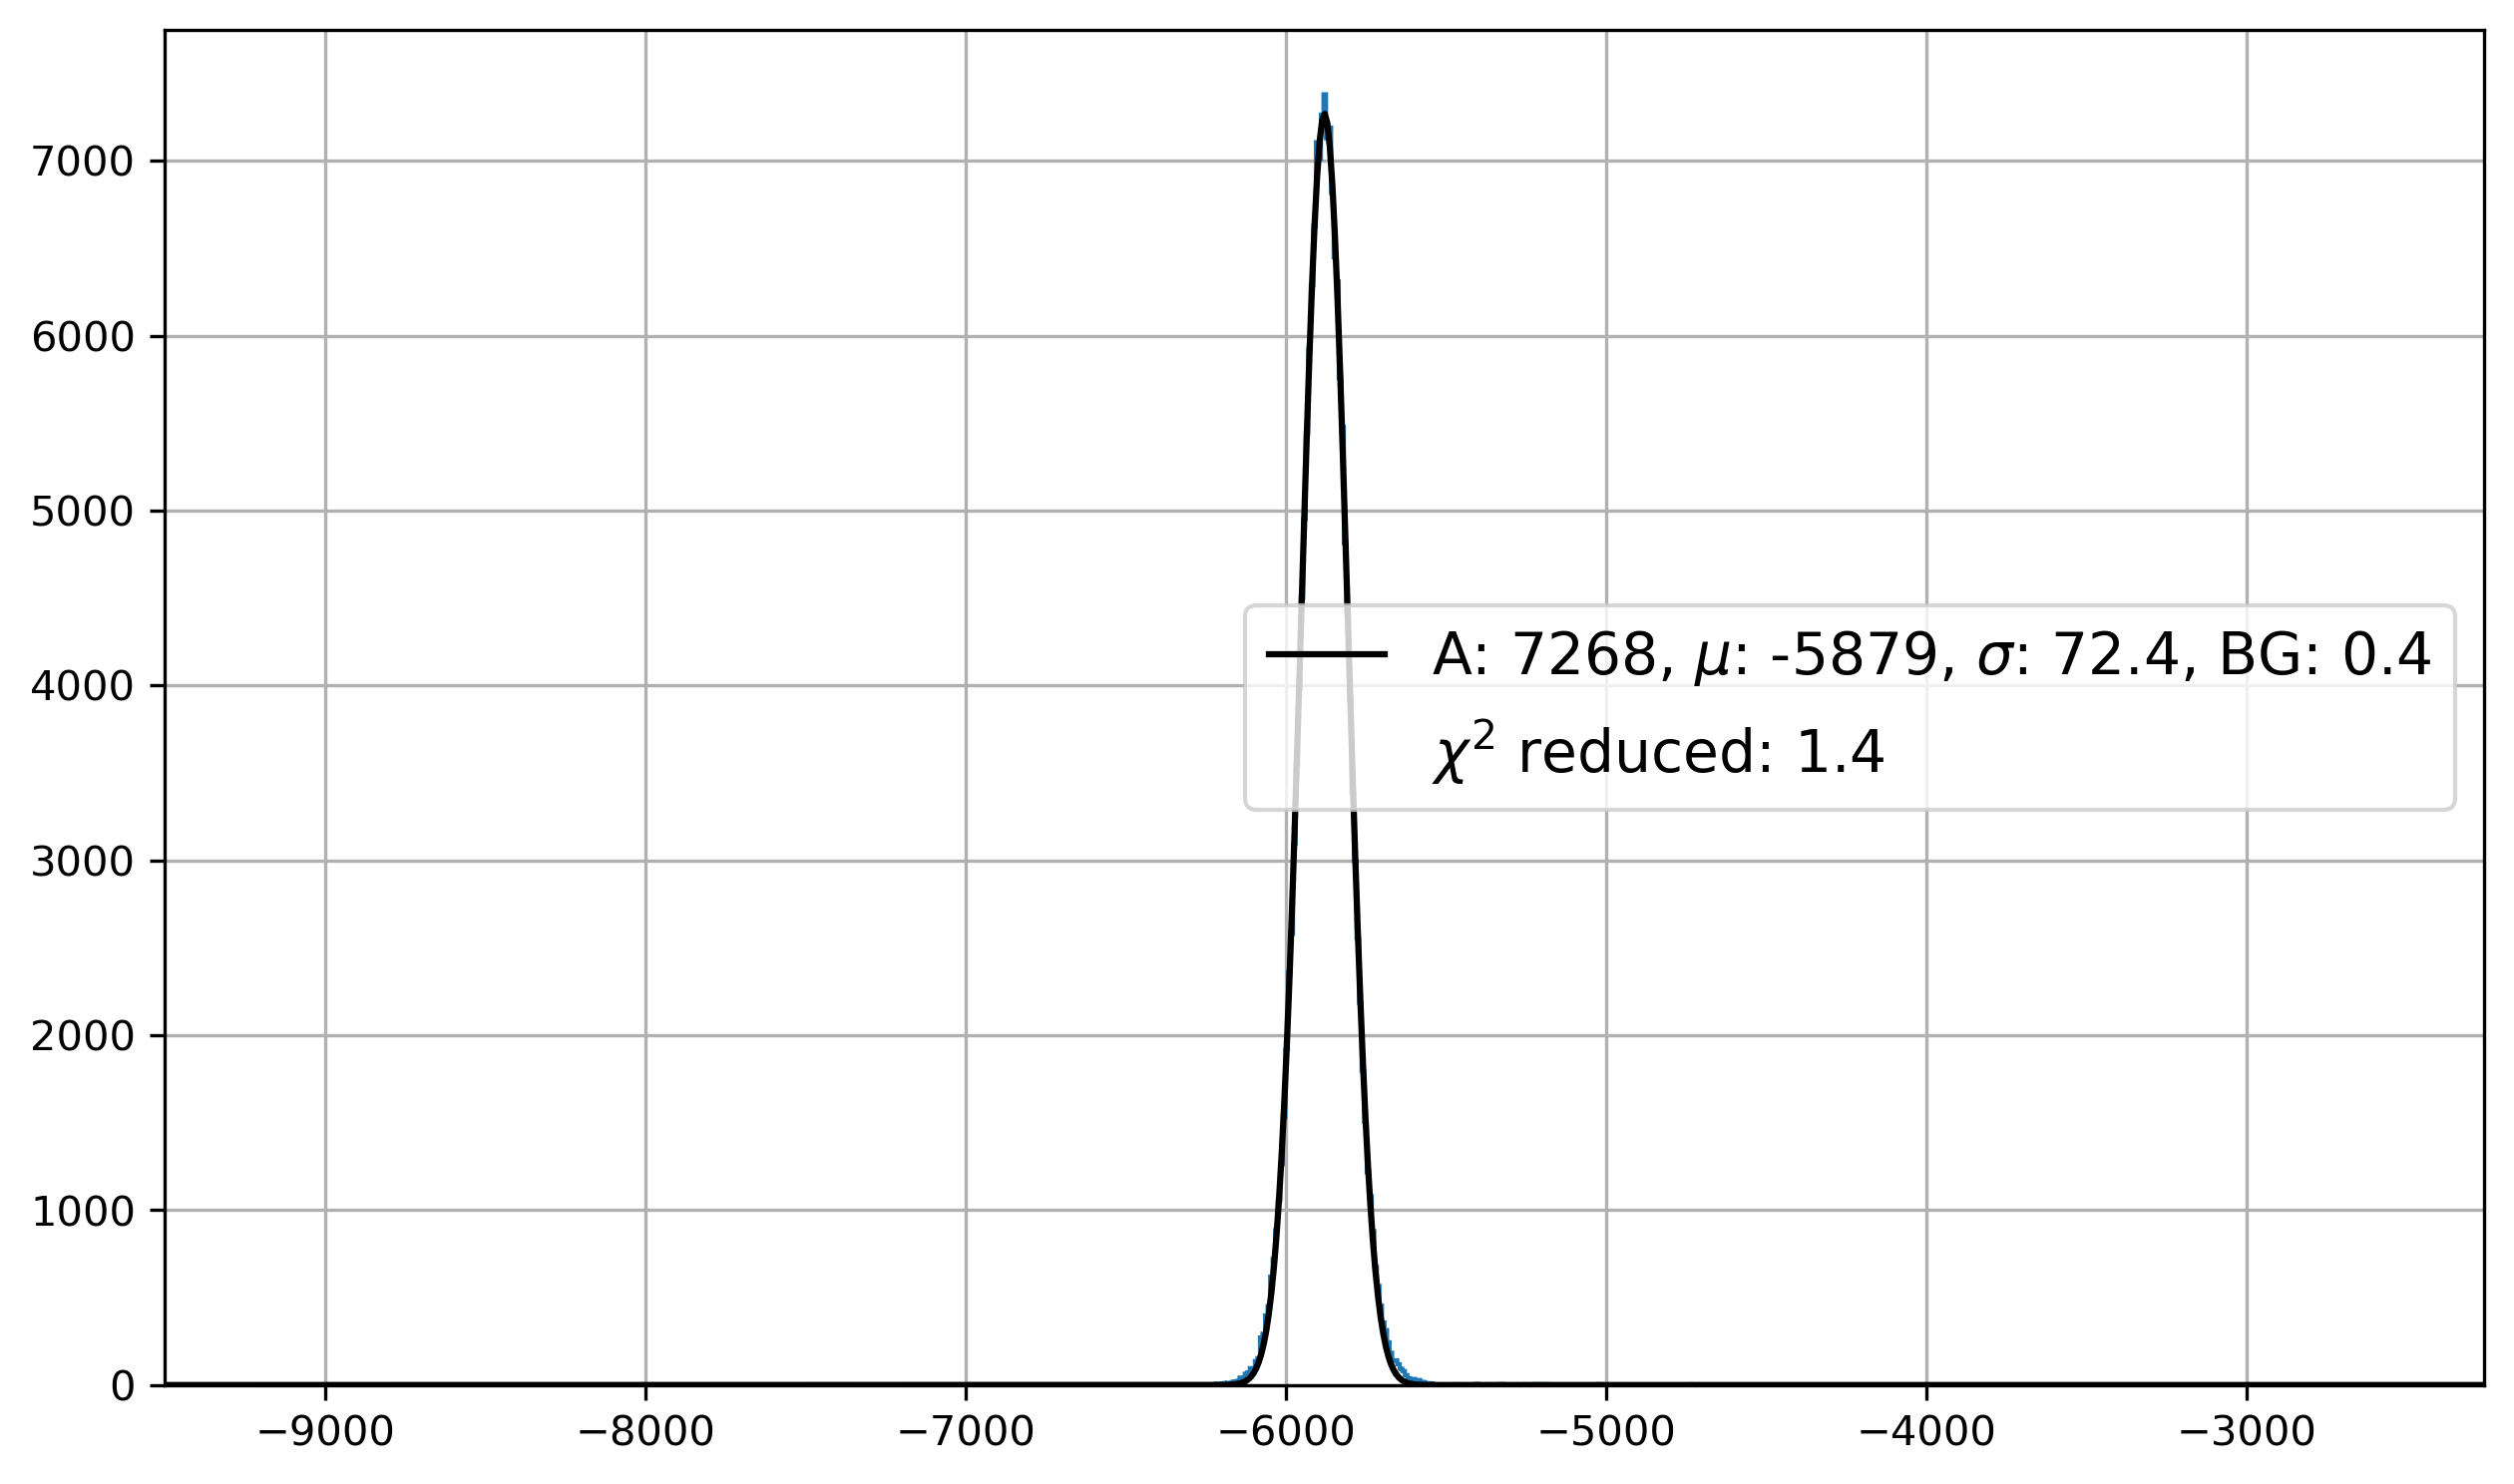

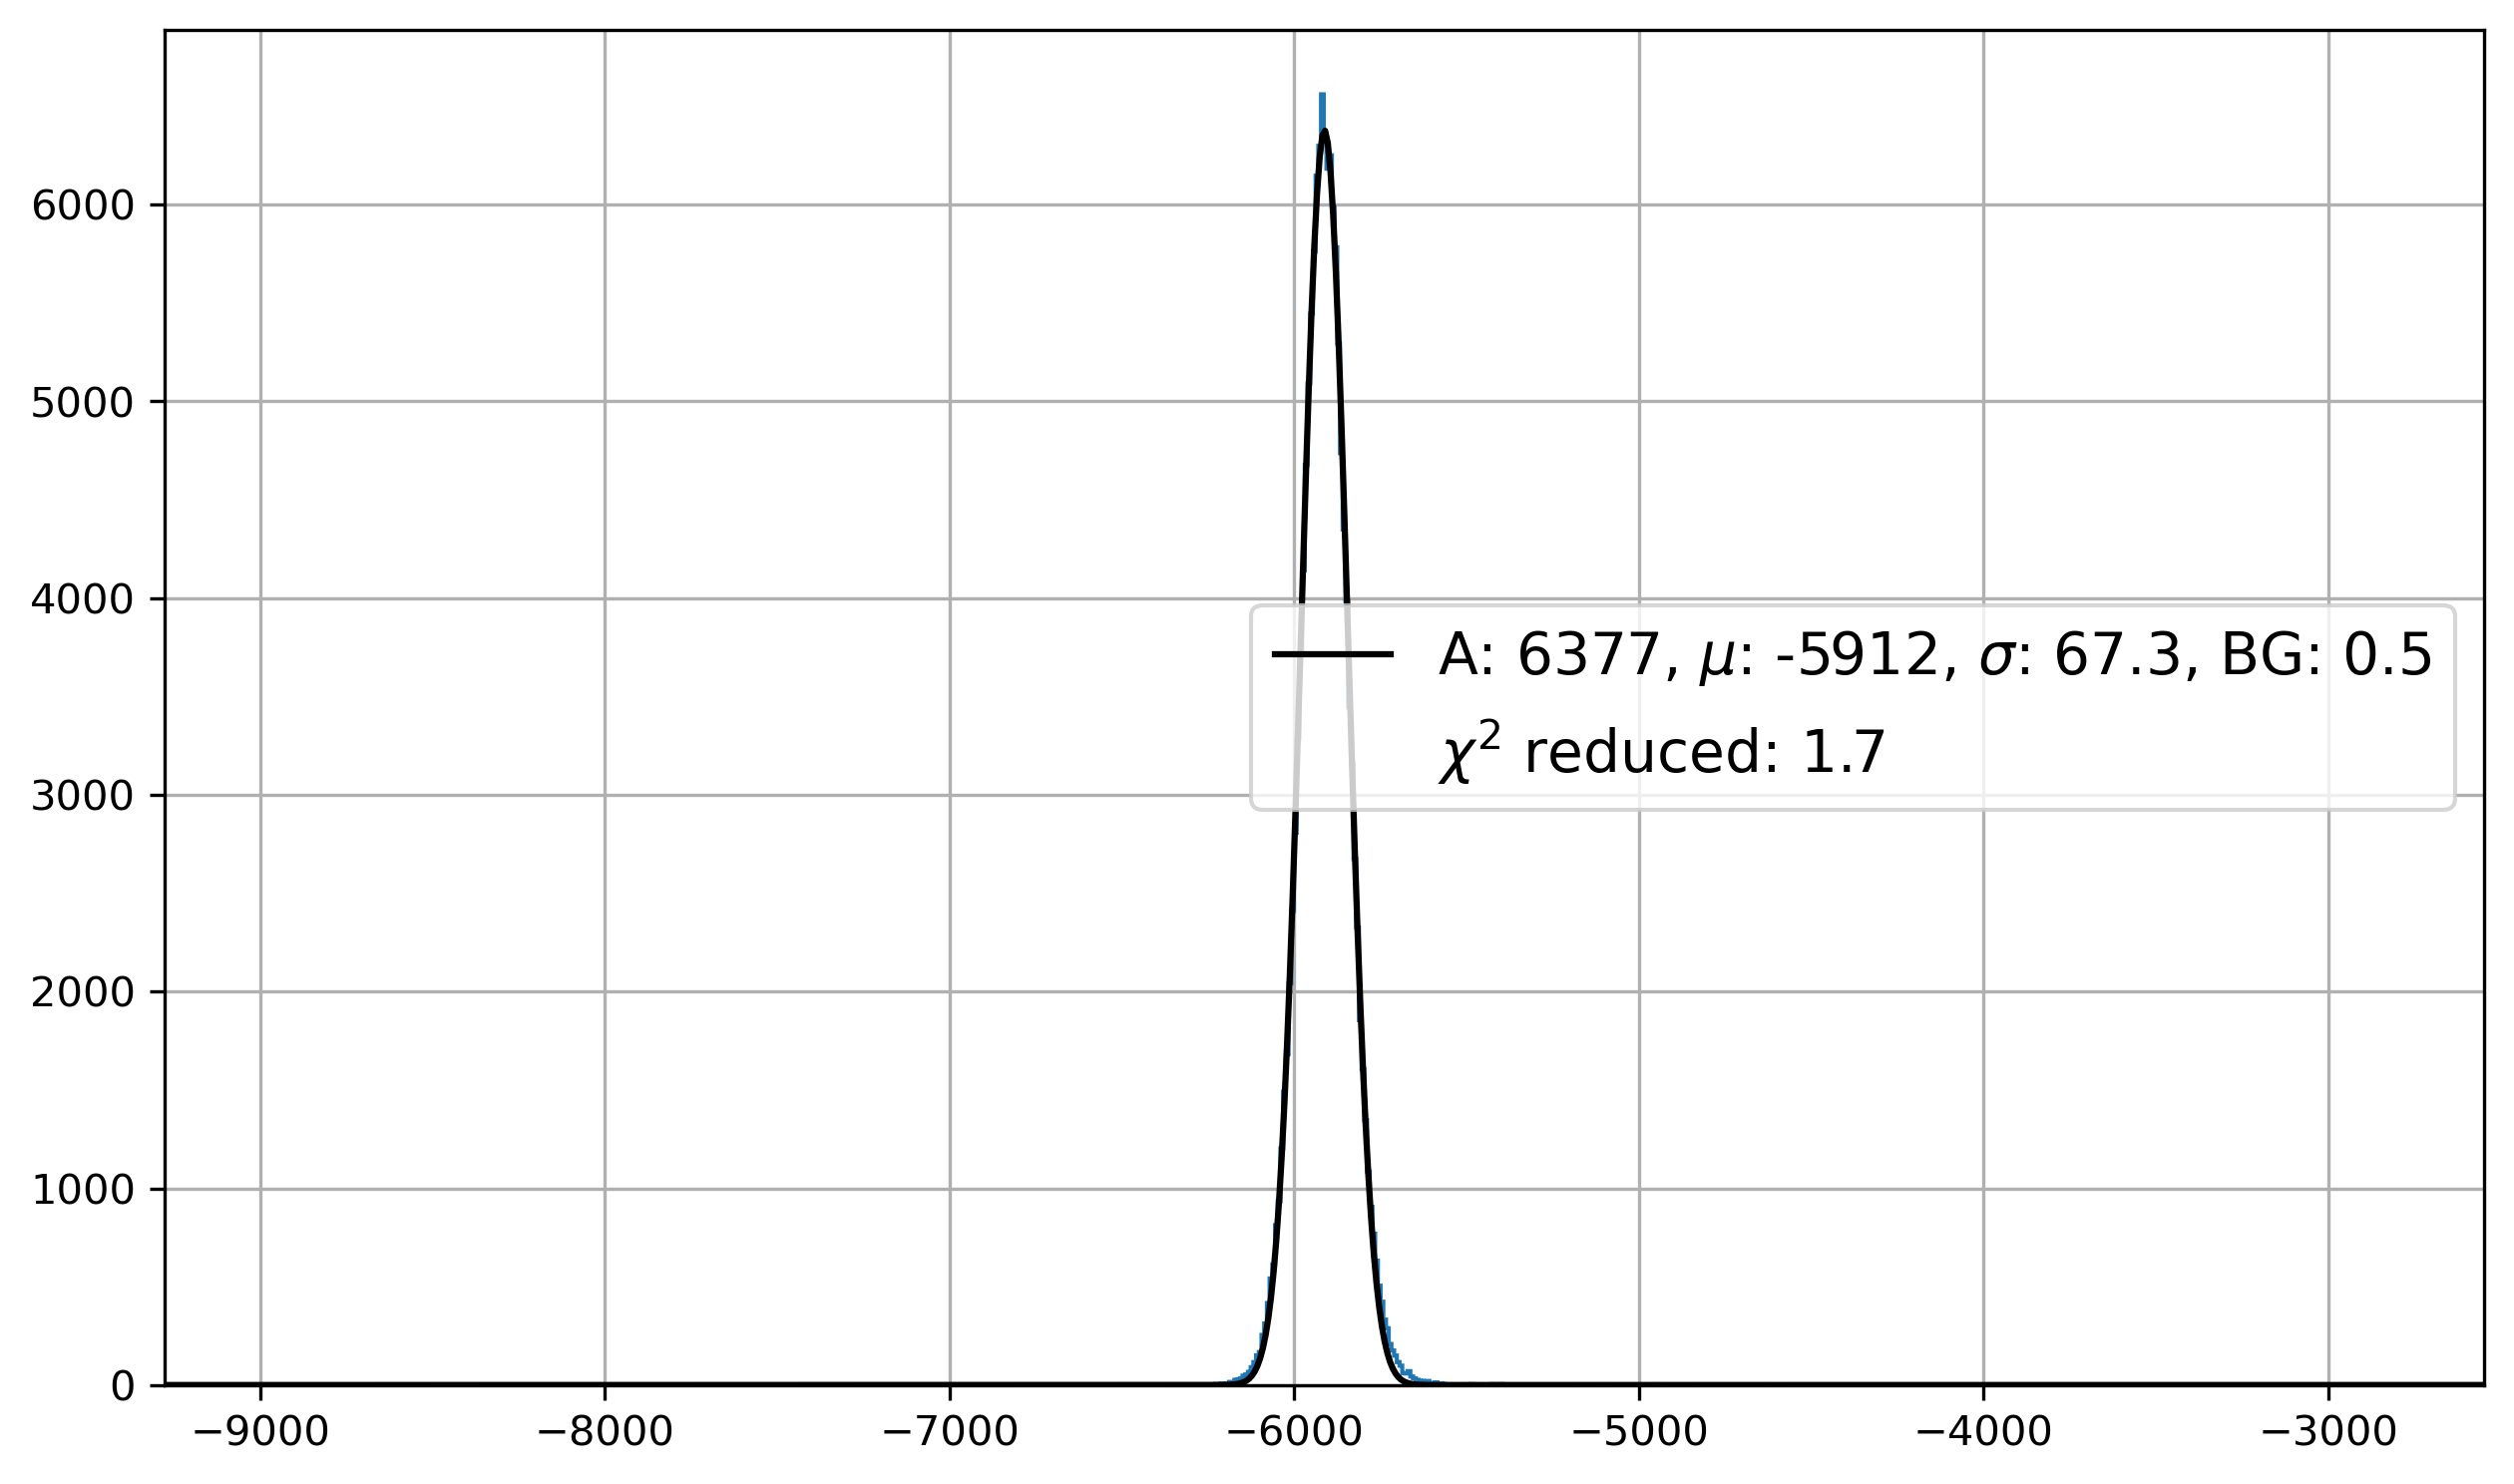

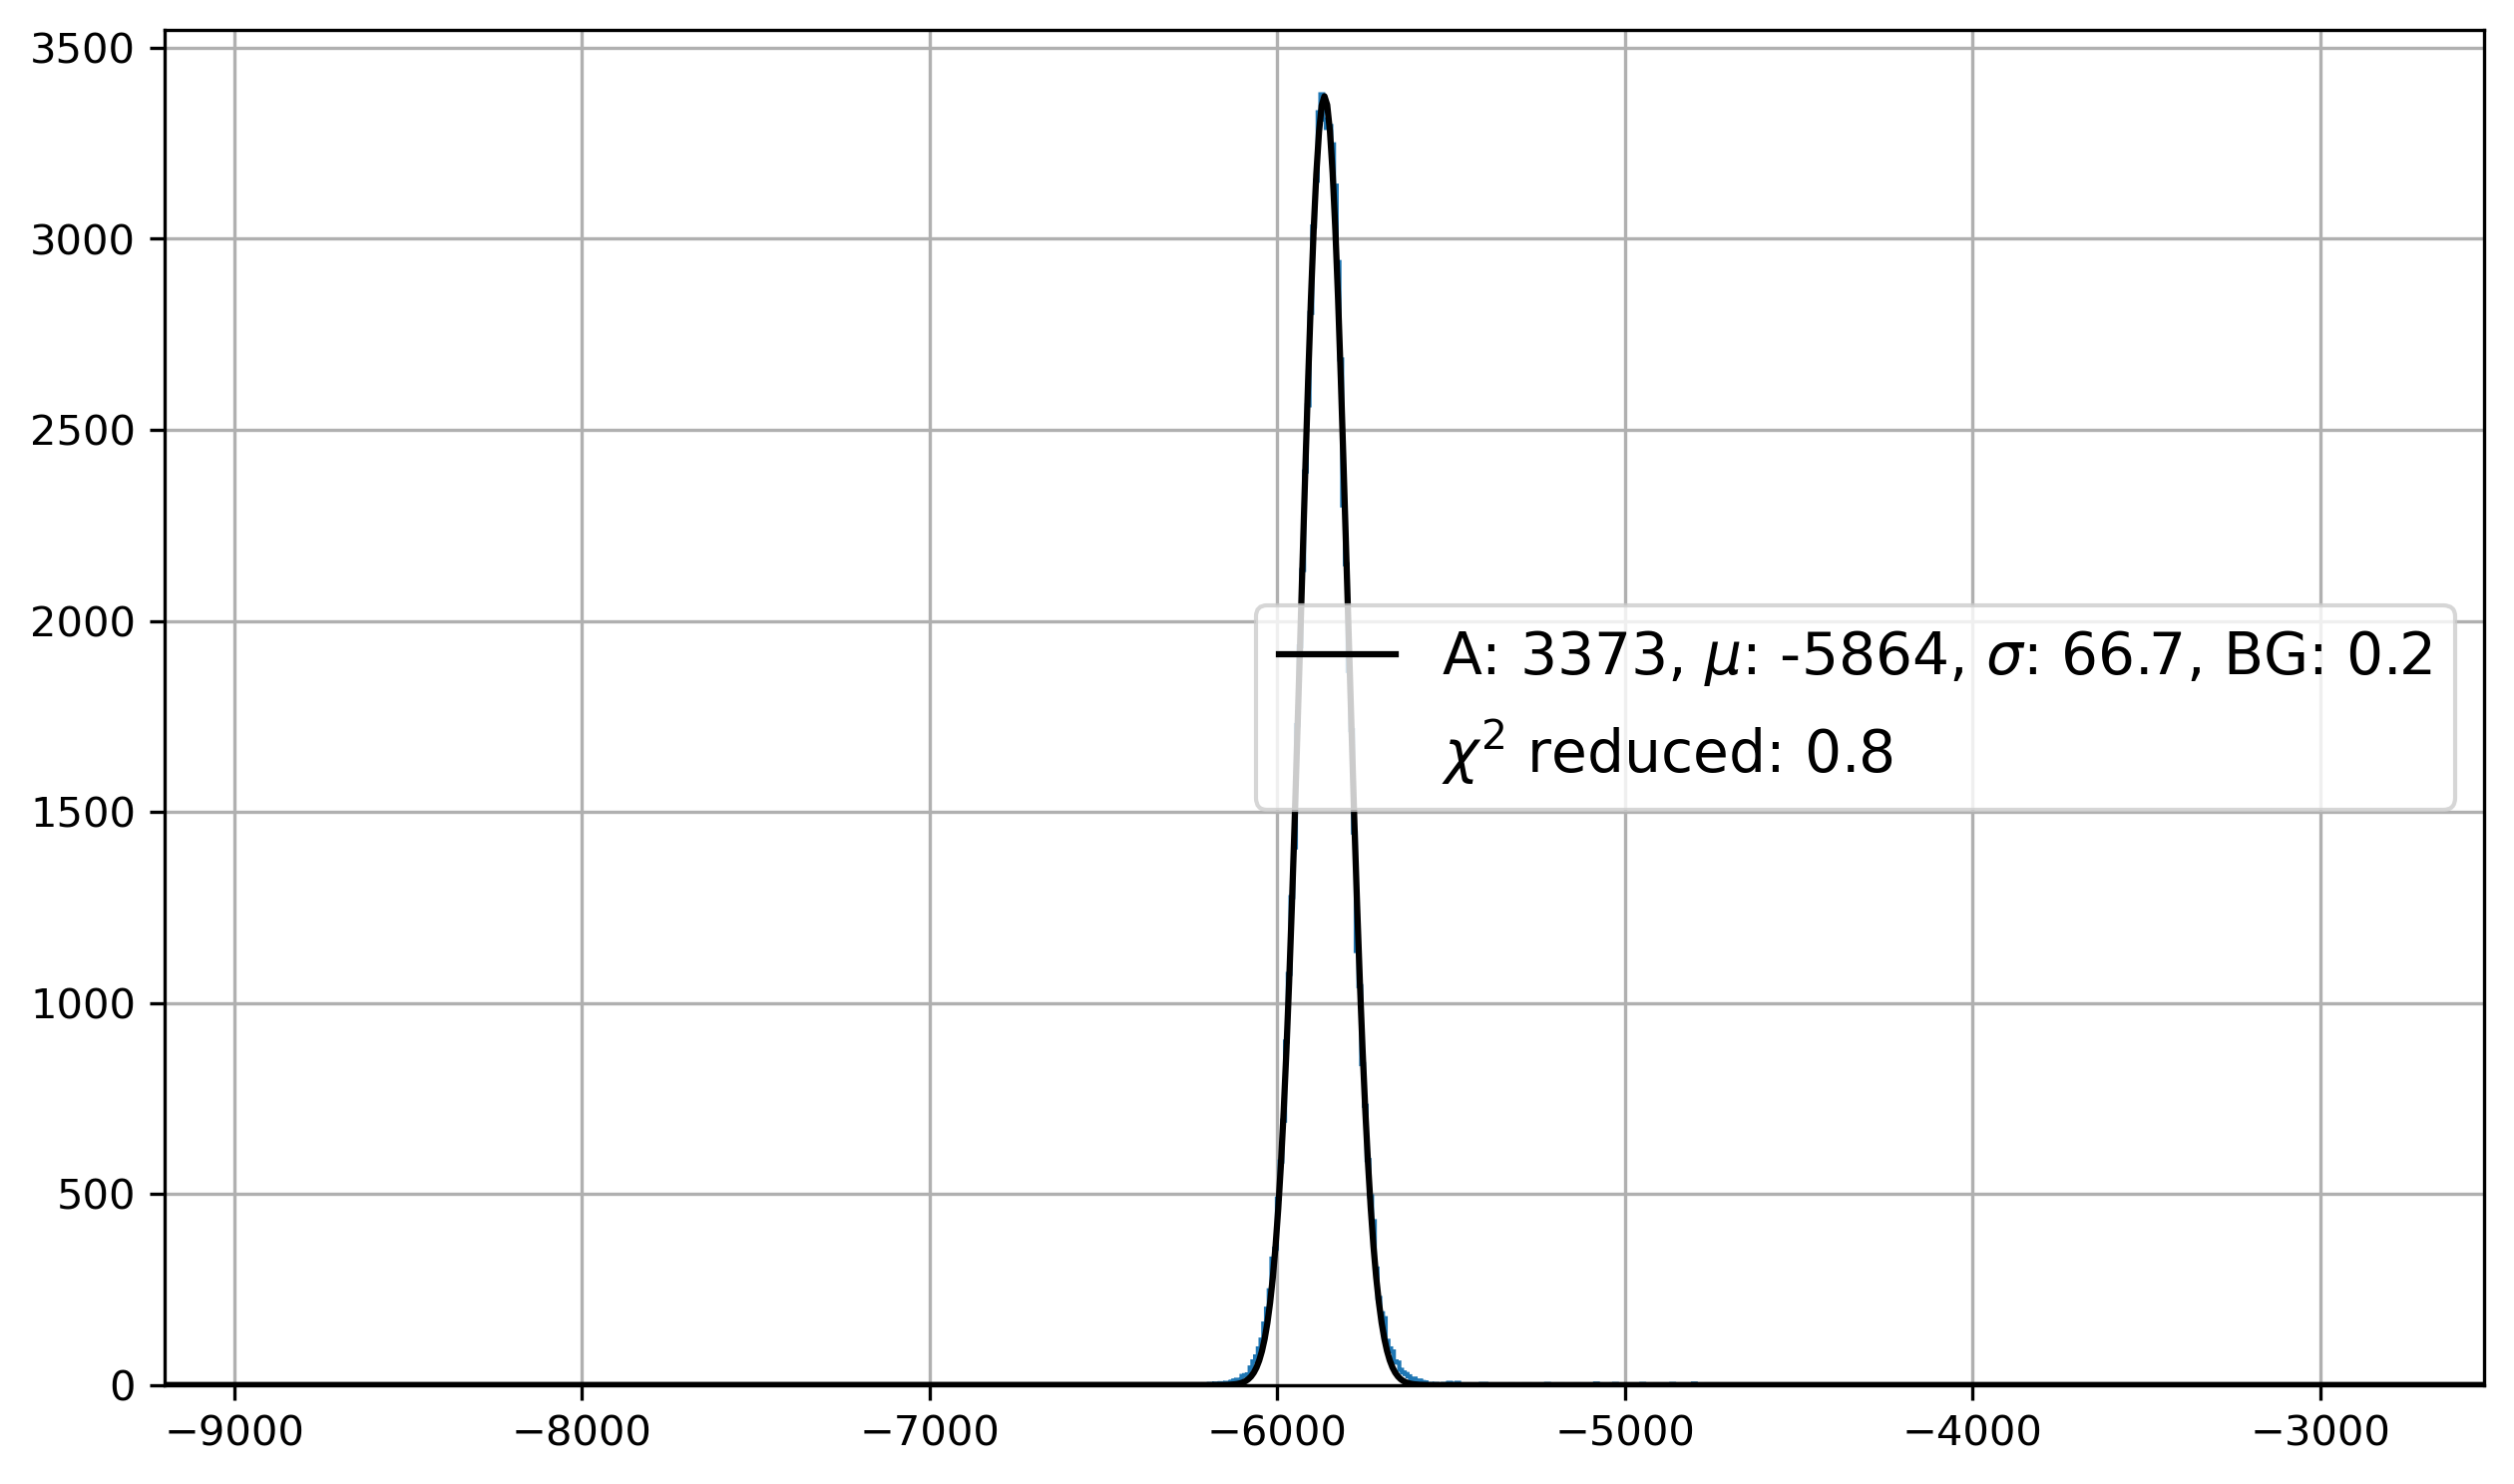

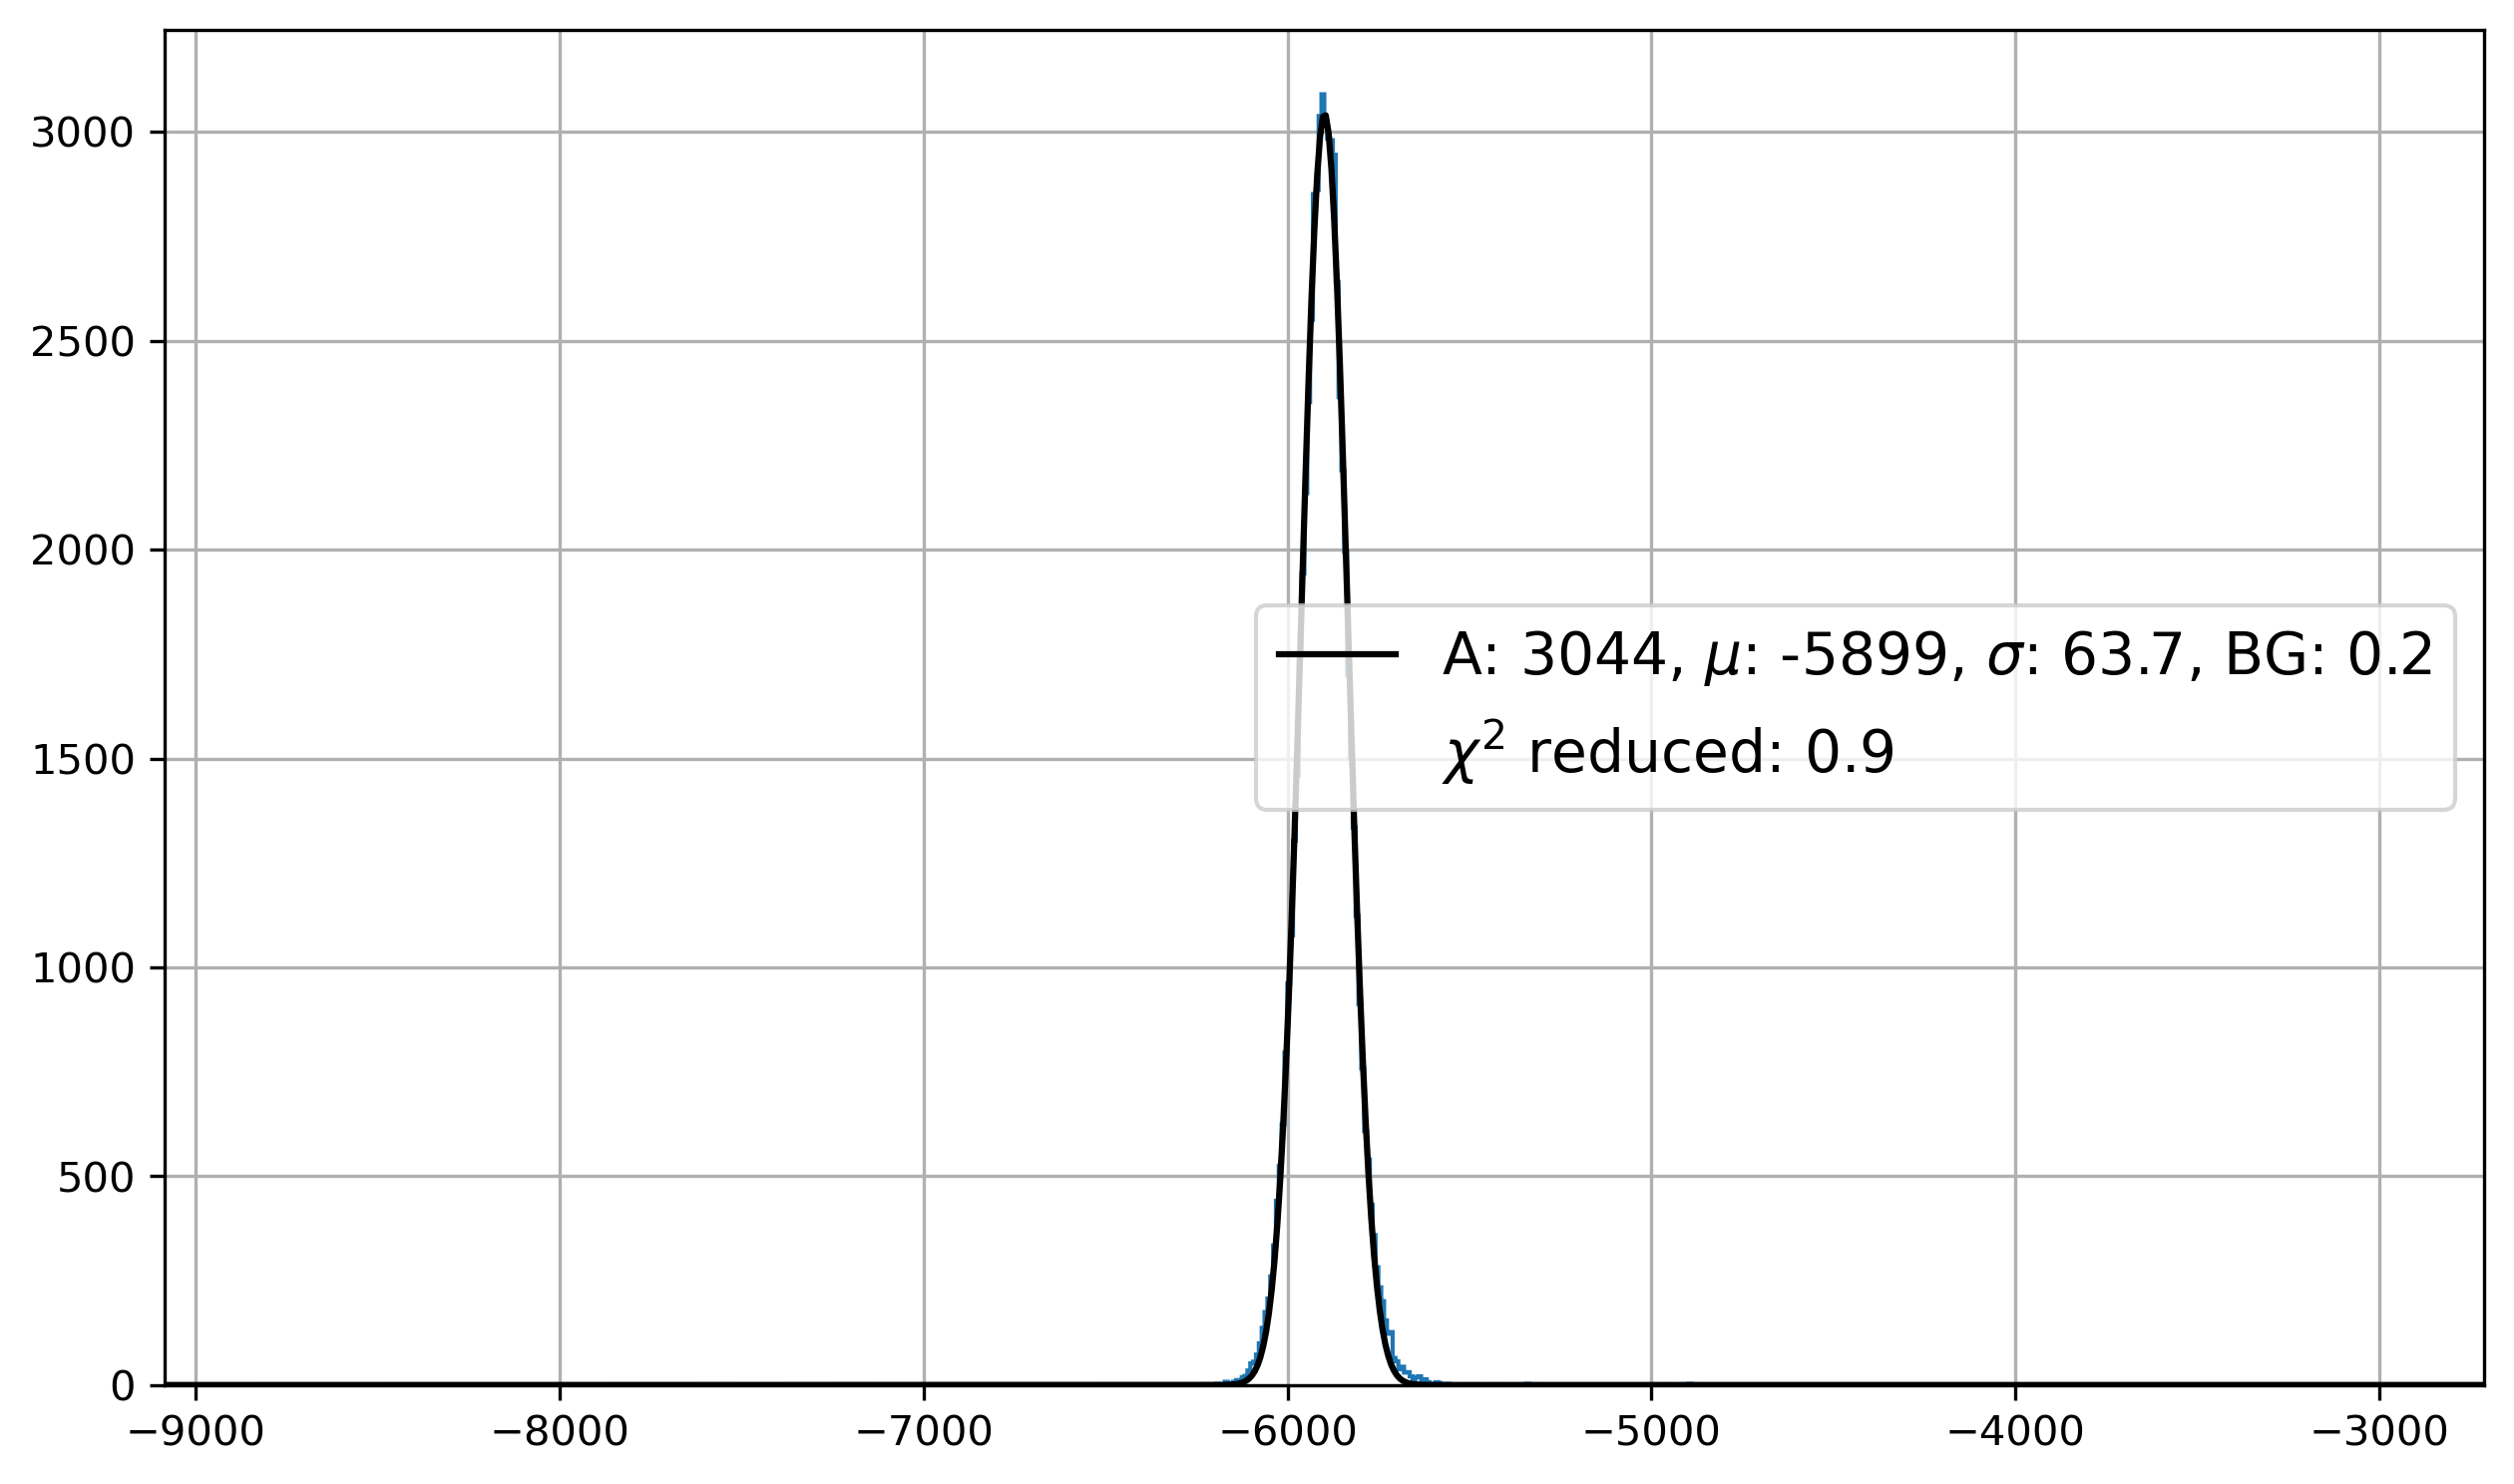

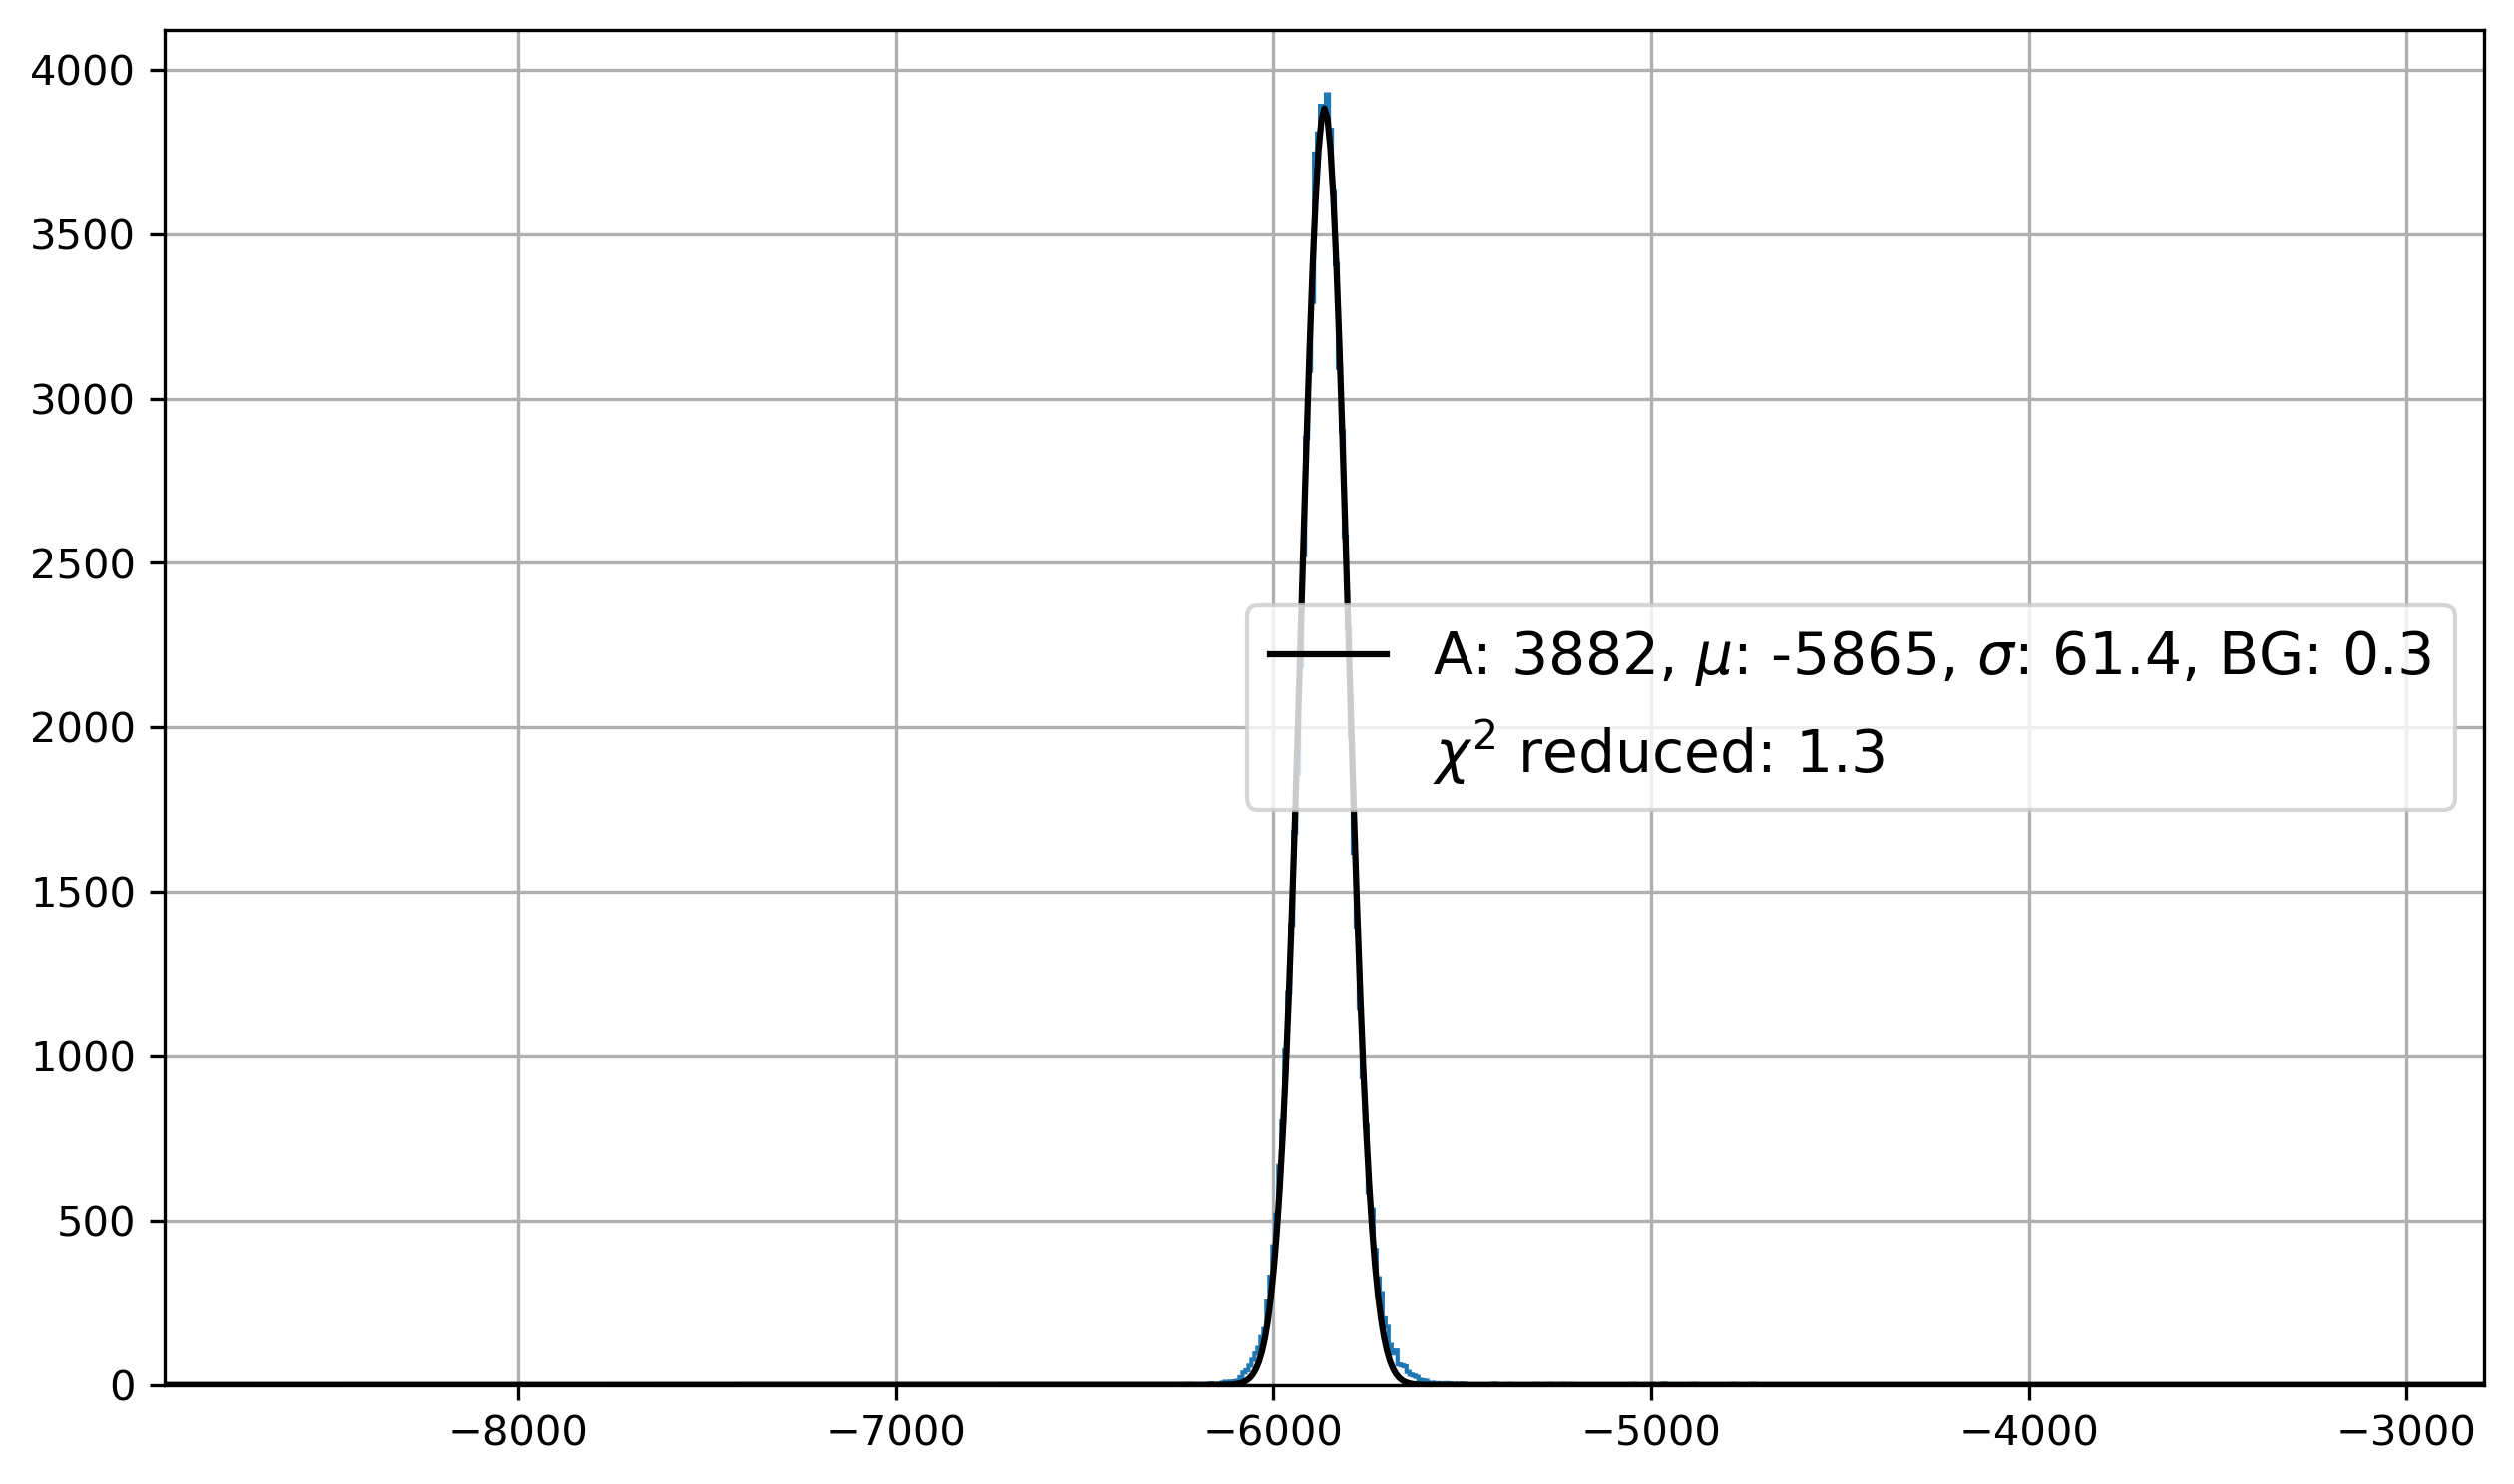

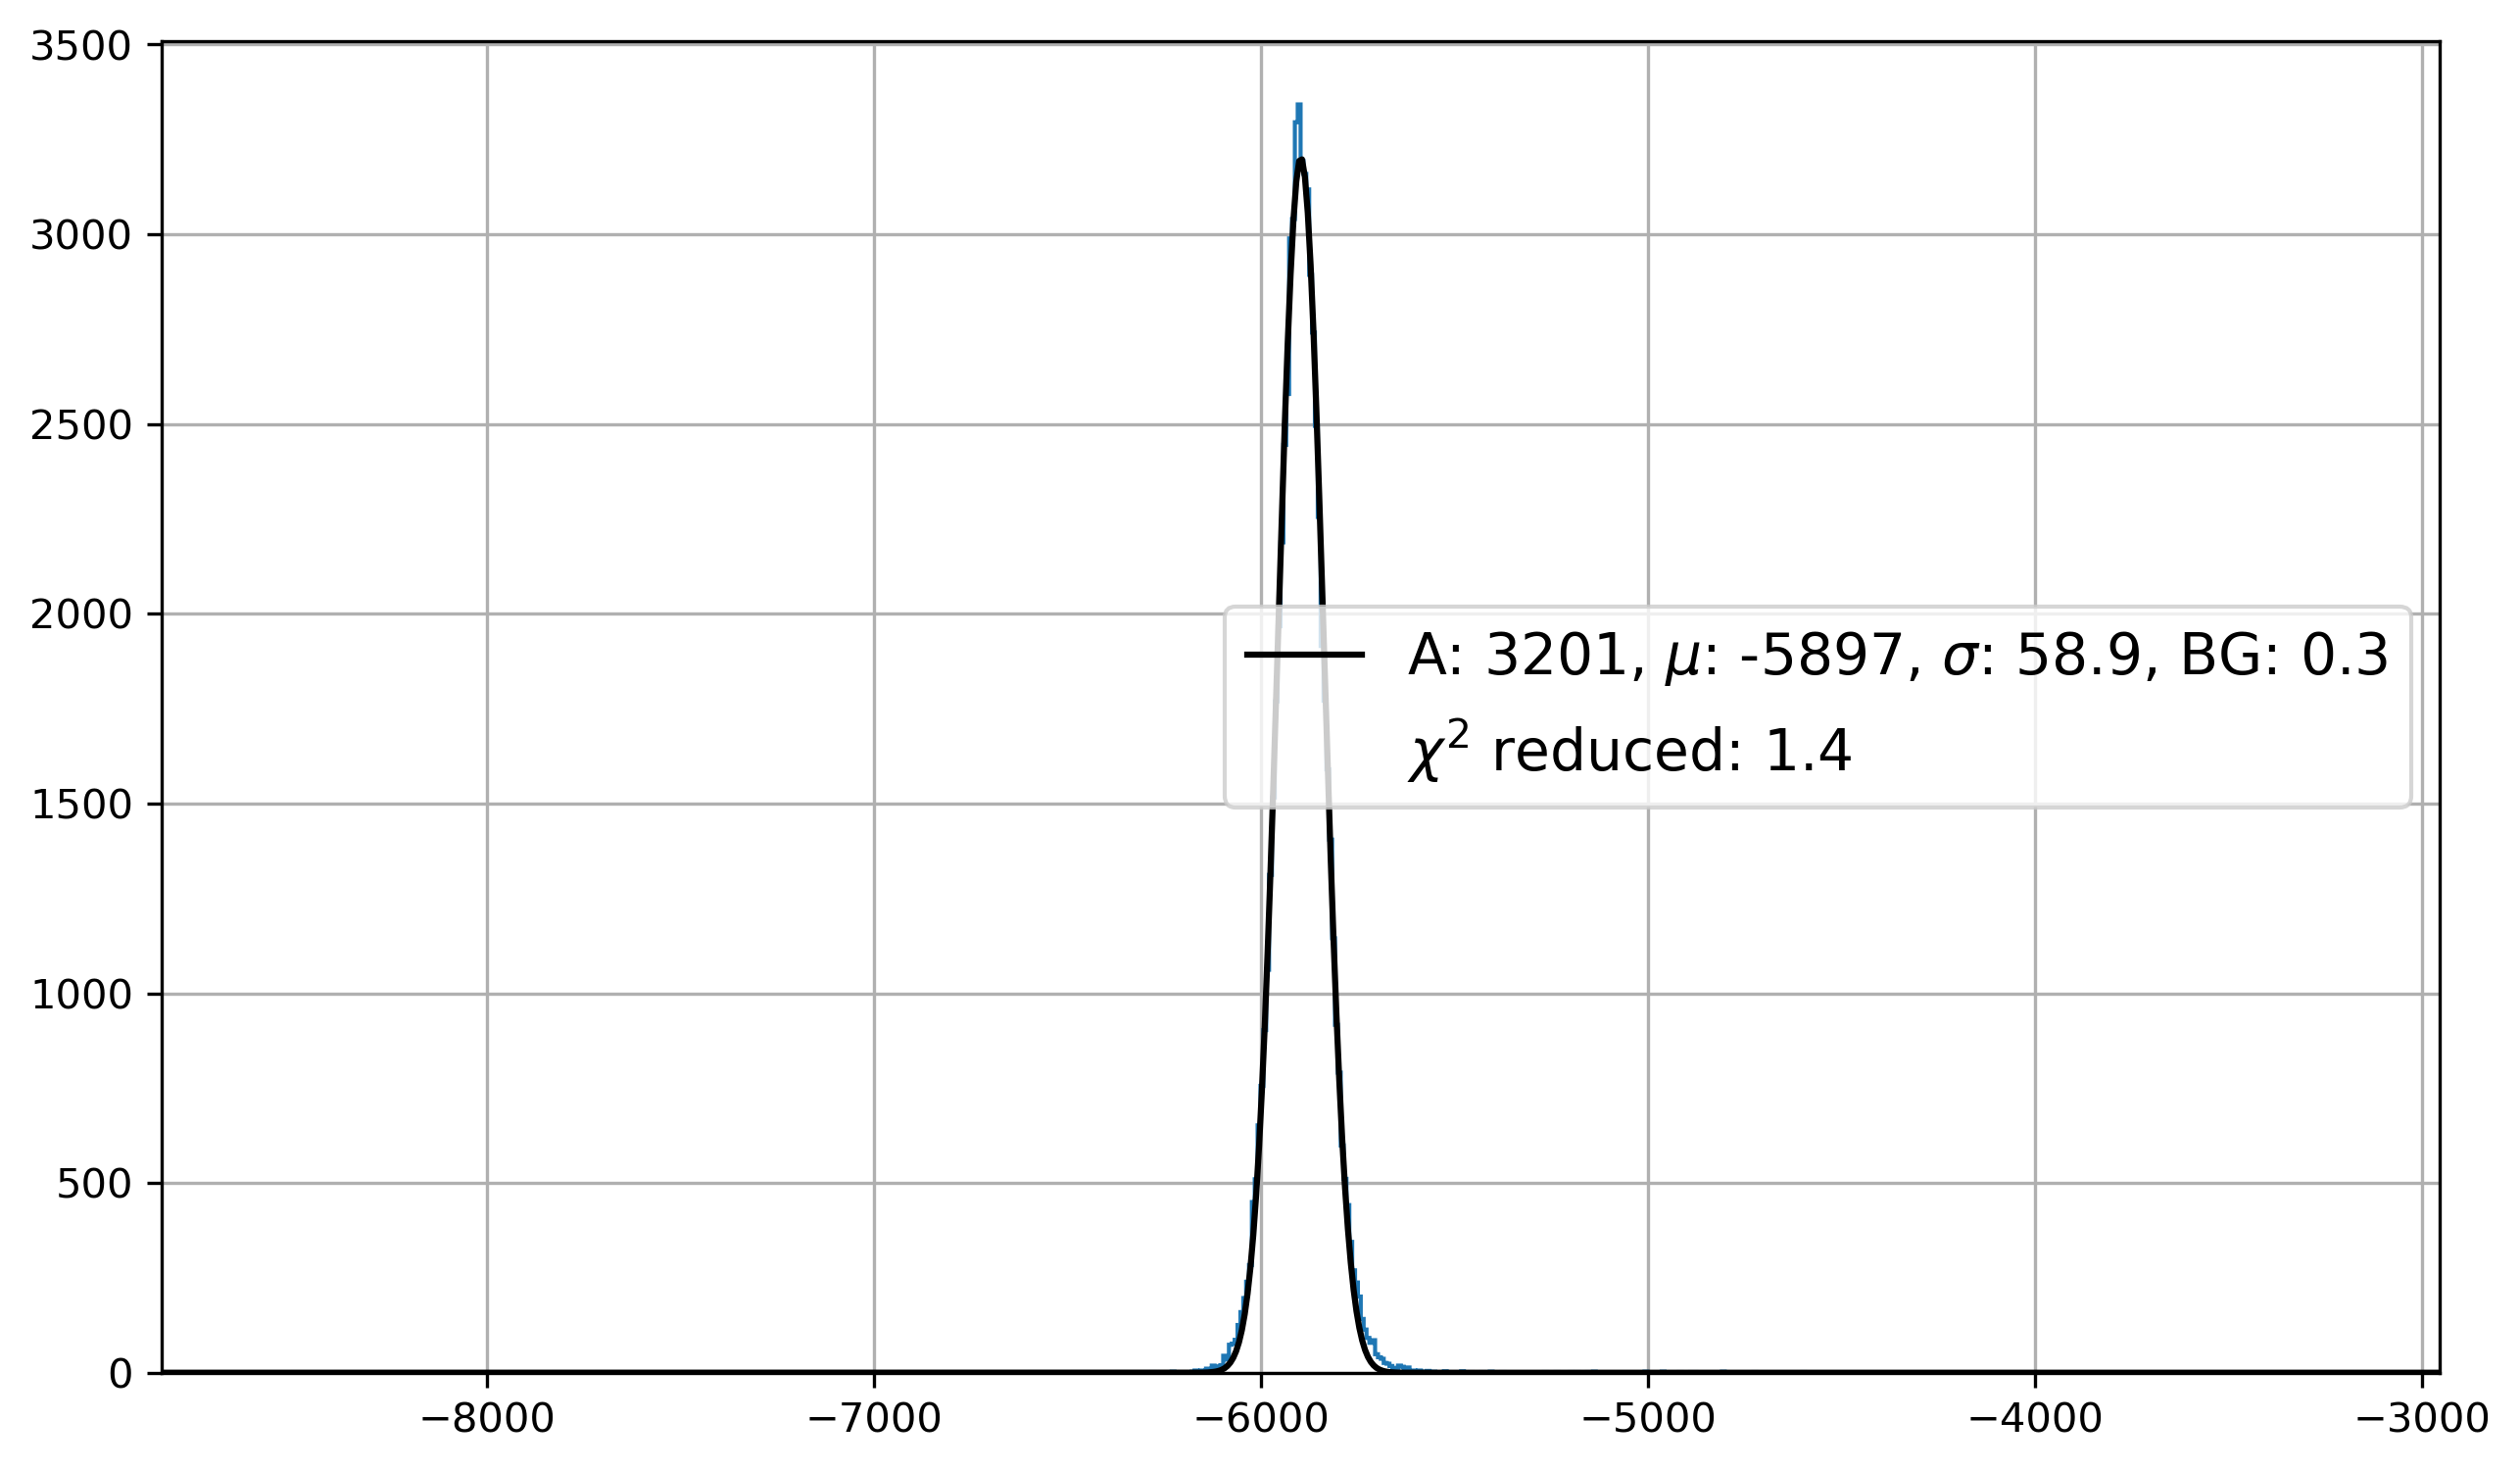

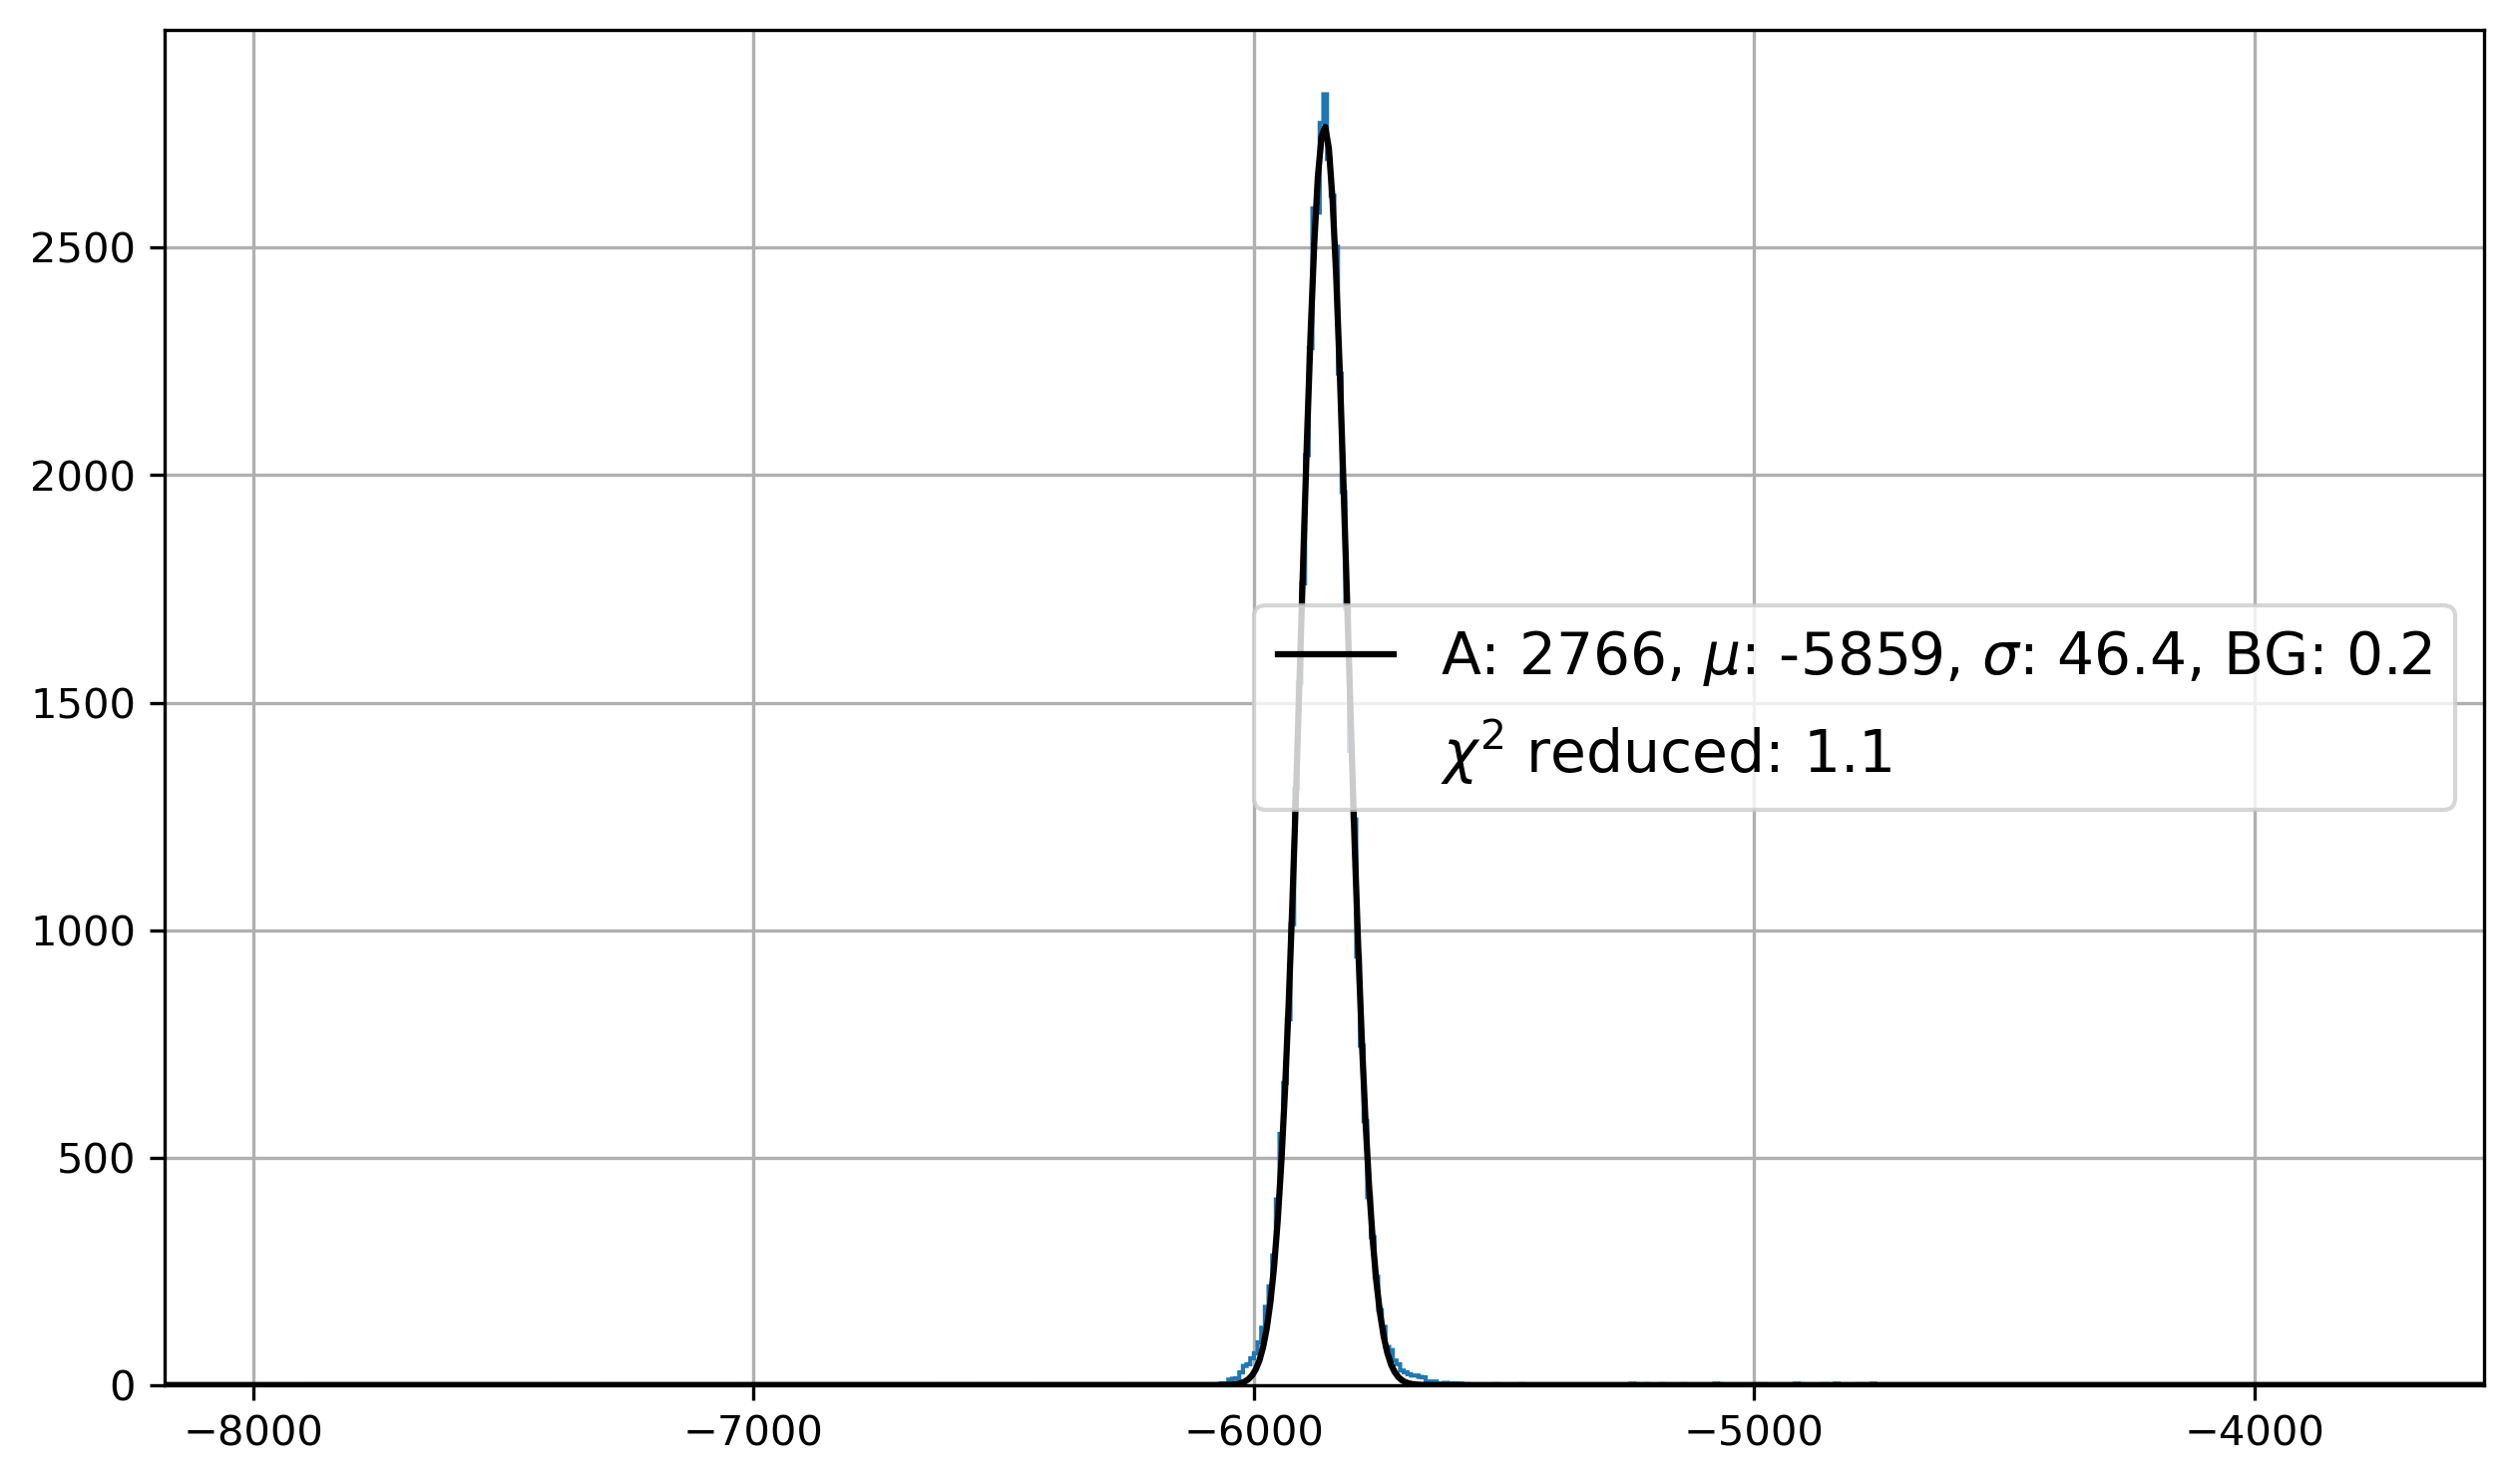

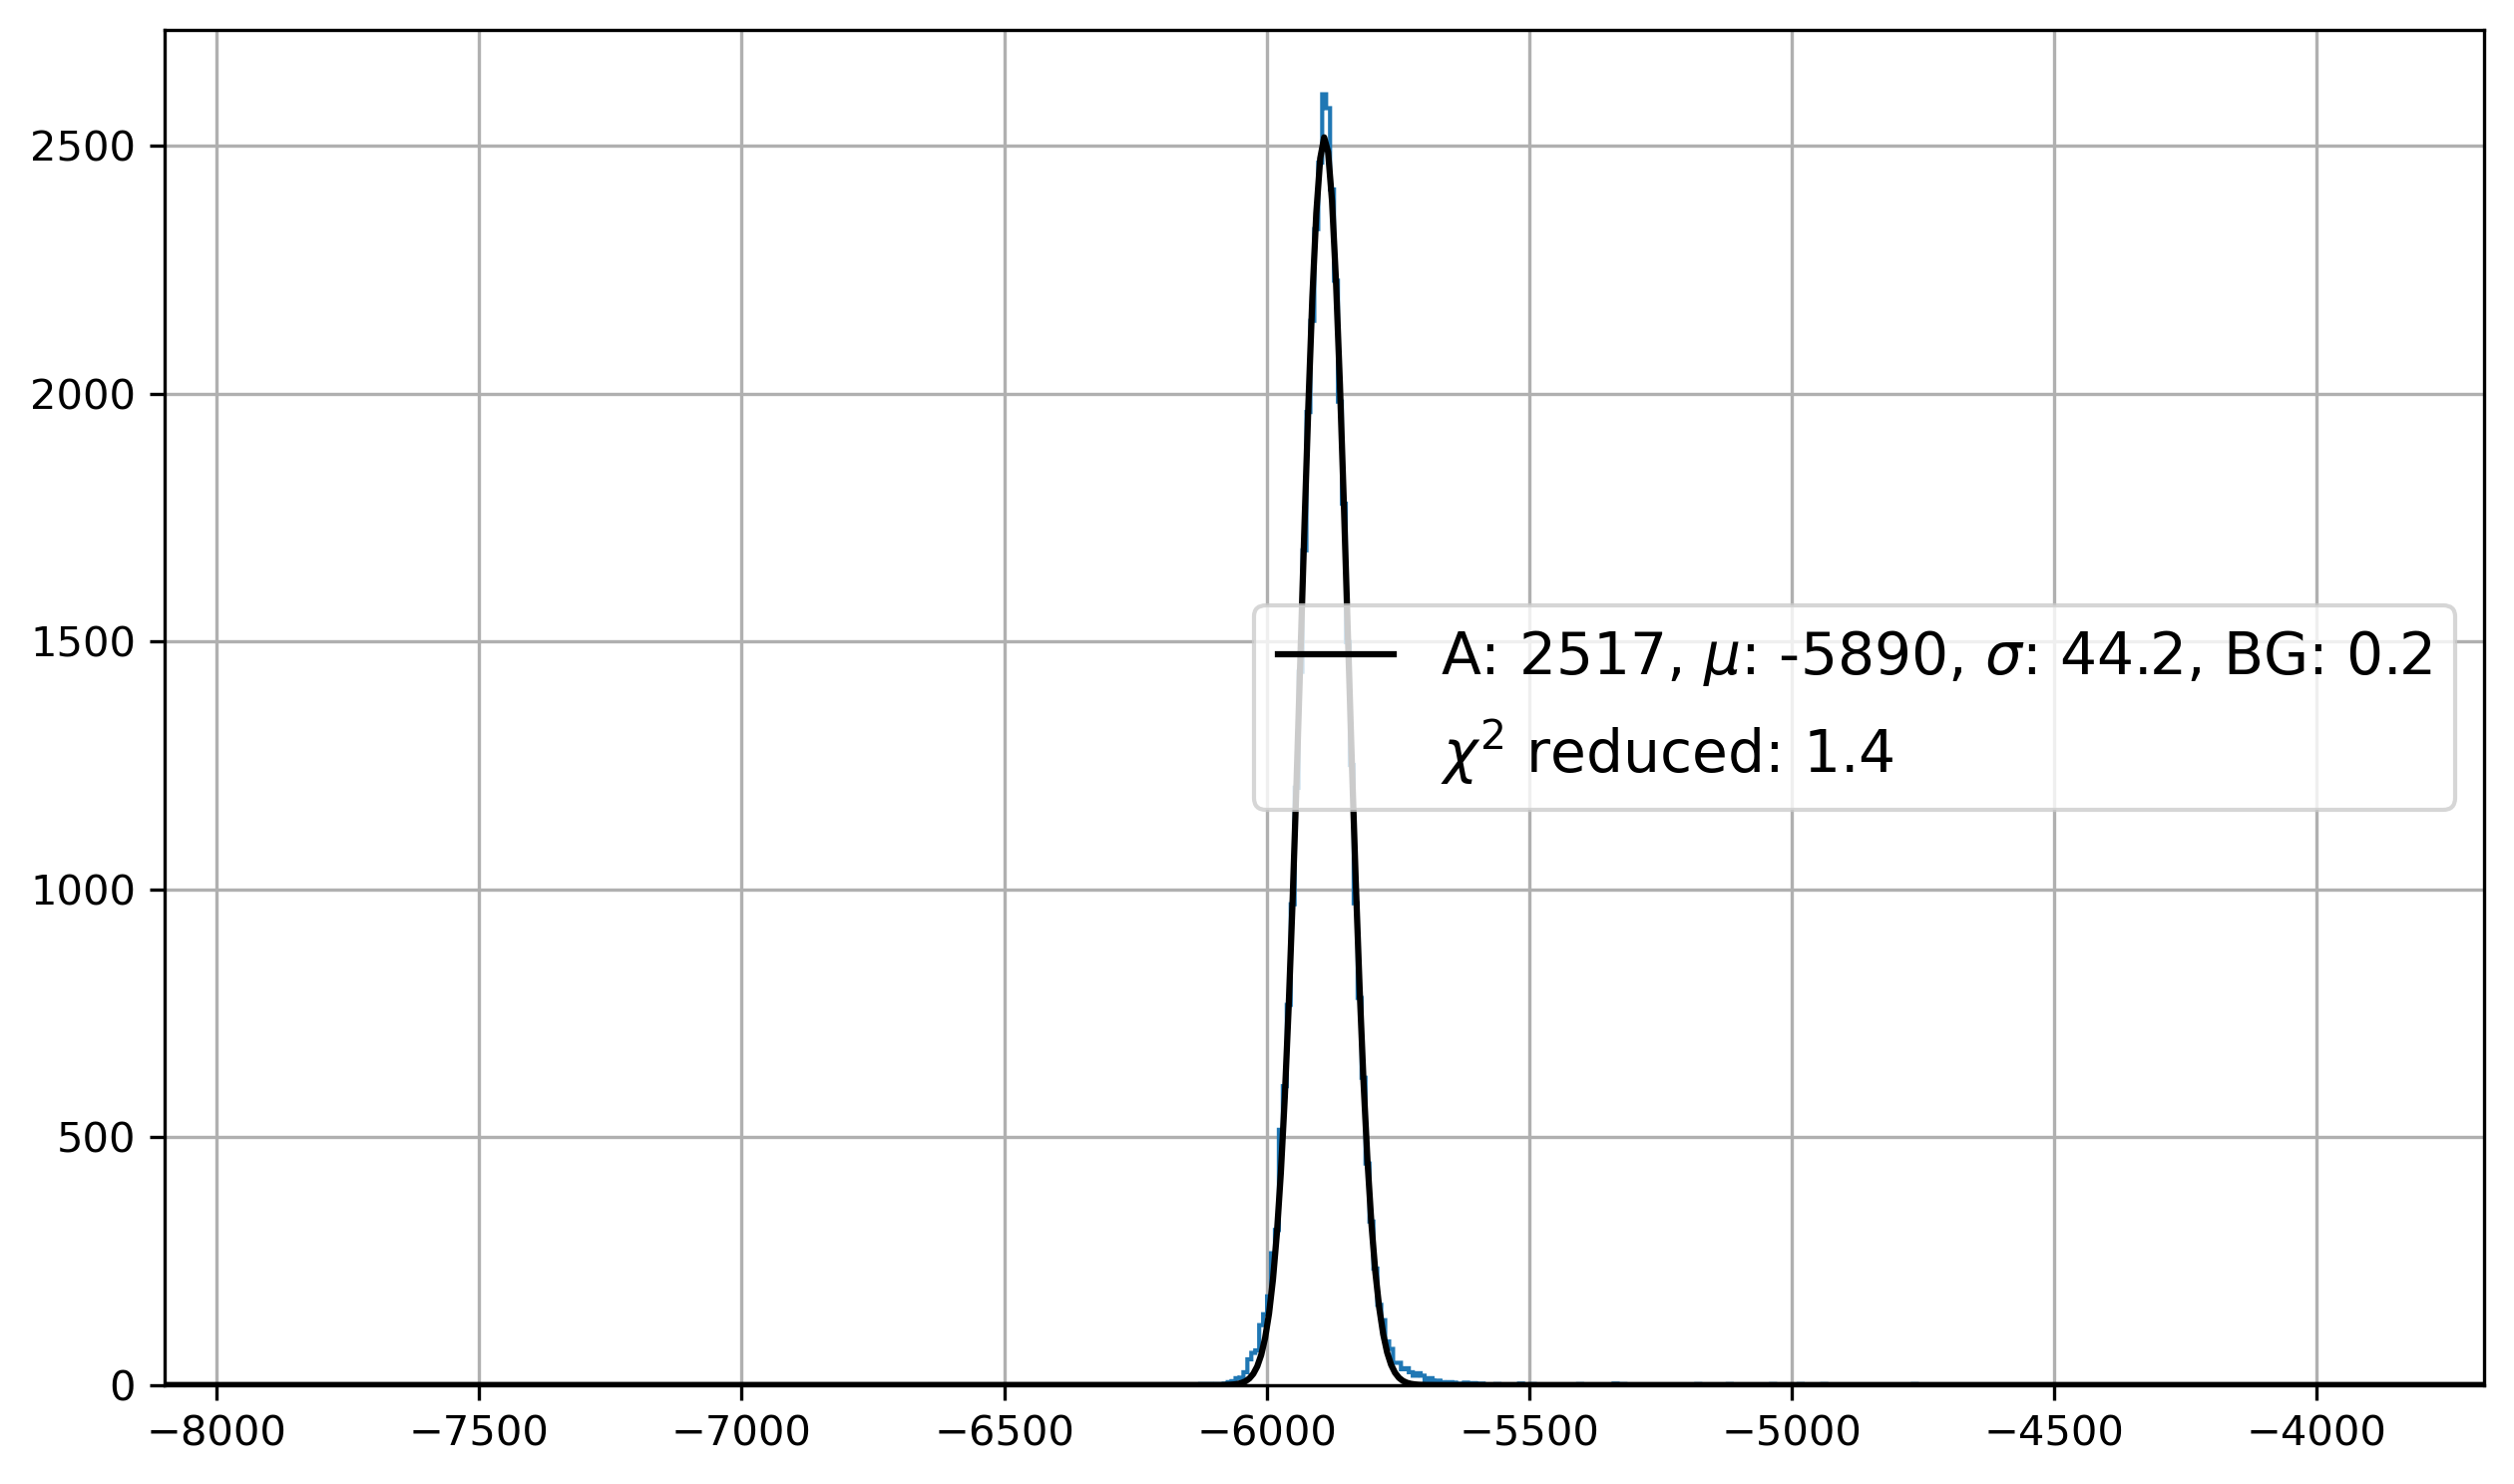

In [113]:

SAVE = True
save_path = f'../various plots/{this_sensor}/{key_to_study}/'
if not os.path.isdir(save_path):
    os.mkdir(save_path)

### I'm starting to think that putting the values in a list is not working
for this_batch in df_analysis.index.levels[0]: ### batches
    for S in df_analysis.index.levels[1]:        ### scopes
        ### get only the DUTs that I need
#         DUTs = get_DUT_from_index(list(df_analysis.loc[idx[this_batch,S,:]].index))
        df = load_batch(this_batch,S)
       
        print(f"MCP: {dict_of_batches[this_batch].S[S].channels['Ch1'].voltage} V, angle: {dict_of_batches[this_batch].angle}°", f"temperature:{dict_of_batches[this_batch].tempA}°C")
        print('channels:', df_analysis.loc[idx[this_batch,S,:]].index)
        for ch in df_analysis.loc[idx[this_batch,S,:]].index:      ### channels
            ### EXTRACTING DATA
            match ch:
                case 'Ch1': dut=-1
                case 'Ch2': dut=1
                case 'Ch3': dut=2
                case 'Ch4': dut=3
                case other: logging.error("wrong channel name")
            print(f"Batch:{this_batch}, Scope:{S}, Channel:{ch}")
            
            comments = set()

            mins = find_min_btw_peaks(df[f"pulseHeight_{dut}"], bins='rice', plot=False)
            geometry_cut = geometry_mask(df, DUT_number=dut, bins=bins1)[0]
            time_cut = time_mask(df, dut, bins=5000, mask=geometry_cut, plot=False)[0]
            pulseheight_cut = df[f'pulseHeight_{dut}']>mins
            charge_cut = df[f'charge_{dut}']>threshold_charge
            ### restrict the charge fit range, because charge<0 doesn't make sense
#             charge_fit_cut = df[f'charge_{dut}']>0
            all_cut = np.logical_and(np.logical_and(geometry_cut,pulseheight_cut),time_cut)

#             transimpedance = dict_of_batches[this_batch].S[S].get_sensor(ch).transimpedance
            transimpedance = 4700

            name = dict_of_batches[this_batch].S[S].get_sensor(ch).name
            board = dict_of_batches[this_batch].S[S].get_sensor(ch).board
            voltage = dict_of_batches[this_batch].S[S].get_sensor(ch).voltage
            fluence = dict_of_batches[this_batch].S[S].get_sensor(ch).fluence
            MCP_voltage = dict_of_batches[this_batch].S[S].get_sensor('Ch1').voltage
            temperature = dict_of_batches[this_batch].tempA
            angle = dict_of_batches[this_batch].angle
            
            try:
                charge_fit_file = f"charge_fit_results_{this_batch}_{S}_{dut}.csv"
                charge_fit_df = pd.read_csv(os.path.join(charge_fit_dir,charge_fit_file), skiprows=1)
                charge = charge_fit_df["MPV"].iloc[0]
                charge_error = charge_fit_df["MPV_error"].iloc[0]
            except FileNotFoundError:
                logging.error("Charge file not found")
                charge, charge_error = -1, 0
                comments.add("Charge fit file not found")
            except:
                logging.error("Unknown error when loading charge fit")
                charge, charge_error = -1, 0
                comments.add("Charge fit error")
                

                ### I don't know if I should use only geo+pulse cut or all cuts
            try:
                time_parameters = time_mask(df, dut, bins=5000, mask=np.logical_and(np.logical_and(geometry_cut,pulseheight_cut),charge_cut), plot=True)[1]['parameters']
            except:
                logging.error("Time fit error")
                time_parameters = [0]*4
                comments.add("Time fit error")
                
            eff = efficiency(df[f"charge_{dut}"].loc[all_cut], threshold=4)
            
            match MCP_voltage:  ### last MCP_voltage entry
                case 2500: MCP_resolution = 36.52 # +/- 0.81
                case 2600: MCP_resolution = 16.48 # +/- 0.57
                case 2800: MCP_resolution = 3.73  # +/- 1.33
                case other: logging.error("Incorrect MCP voltage")

        ### I SHOULD CALCULATE THE ERROR PROPAGATION TO THE TIME RESOLUTION
            time_resolution = np.sqrt(time_parameters[2]**2 - MCP_resolution**2)
            print(time_parameters[2], MCP_resolution)
#              ['name', 'board', 'voltage', 'MCP_voltage', 'temperature', 'angle', 'fluence', 'charge', 'charge_error', 'efficiency', 'time_resolution', 'comments', 'exclude']
            df_analysis.loc[(this_batch,S,ch)] = [name, board, voltage, MCP_voltage, temperature, angle, fluence, charge, charge_error, eff, time_resolution, comments, False]

dict_analysis_USTC[key_to_study] = df_analysis.copy()

In [114]:

### select one value from the index channel
# df_analysis.loc[idx[:,:,'Ch2'],['charge']] ### DATAFRAME  
# df_analysis.loc[idx[:,:,'Ch2']]['charge']  ### SERIES

display(df_analysis)



name   board voltage MCP_voltage  \
batch oscilloscope channel                                                 
301   S1           Ch2      USTC2.1-W17-P6-A  CERN-3    -120        2500   
                   Ch3      USTC2.1-W17-P6-A  CERN-3    -120        2500   
408   S1           Ch2      USTC2.1-W17-P6-A  CERN-3    -150        2500   
                   Ch3      USTC2.1-W17-P6-A  CERN-3    -150        2500   
409   S1           Ch2      USTC2.1-W17-P6-A  CERN-3    -165        2500   
                   Ch3      USTC2.1-W17-P6-A  CERN-3    -165        2500   
410   S1           Ch2      USTC2.1-W17-P6-A  CERN-3    -165        2600   
                   Ch3      USTC2.1-W17-P6-A  CERN-3    -165        2600   

                           temperature angle fluence   charge charge_error  \
batch oscilloscope channel                                                   
301   S1           Ch2       21.733333   0.0       0  10.9943     0.010024   
                   Ch3       21.733333   0.0       0  11.4969     0.011709   
408   S1           Ch2       21.366667   0.0       0  16.1779     0.019964   
                   Ch3       21.366667   0.0       0  16.9402     0.023909   
409   S1           Ch2       21.666667   0.0       0  20.6535      0.02168   
                   Ch3       21.666667   0.0       0  21.8988      0.02525   
410   S1           Ch2            21.7   0.0       0  20.6629     0.028489   
                   Ch3            21.7   0.0       0  21.9306     0.033023   

                           efficiency time_resolution comments exclude  
batch oscilloscope channel                                              
301   S1           Ch2      99.701962       62.558825       {}   False  
                   Ch3       99.71338       56.521738       {}   False  
408   S1           Ch2      99.765559       55.819048       {}   False  
                   Ch3      99.772188       52.248191       {}   False  
409   S1           Ch2       99.73821       49.373668       {}   False  
                   Ch3      99.757956       46.171651       {}   False  
410   S1           Ch2      99.688523       43.333881       {}   False  
                   Ch3      99.751854       40.982201       {}   False

### Save the data
save the dictionary of dataframes

In [115]:
with open(USTC_file_name, 'wb') as f:
    pickle.dump(dict_analysis_USTC, f)

## Plots

In [128]:
def update_prop(handle, orig):
    handle.update_from(orig)
    handle.set_marker("")


In [71]:
markers = ('o','v','s','*','X','P','D','2')
colormap = ['k','b','g','r','orange','yellow','purple']


#### Bias voltage vs MPV of charge

In [38]:
# ### WITHOUT ANGLE
# SAVE = True

# list_of_texts = []
# fig, ax = plt.subplots(figsize=(10,6), dpi=300)
# for i, ch in enumerate(['Ch2','Ch3']):
#     voltage = np.array(df_analysis.loc[idx[:,:,ch]]['voltage'])
#     charge = np.array(df_analysis.loc[idx[:,:,ch]]['charge'])
#     batch_labels = np.array(df_analysis.loc[idx[:,:,ch]].index.get_level_values('batch'))
    
#     ax.plot(voltage, charge,
#         marker='o', markersize=10, alpha=0.5, color=colormap[i+1],
#         label=f"{ch}")
    
#     for x,y,label in zip(voltage,charge,batch_labels):
#         list_of_texts.append(ax.text(x,y, label))
# adjust_text(list_of_texts)    
    
# ax.set_title(f"Bias voltage vs MPV of the charge, USTC", fontsize=20)
# ax.set_xlabel("Voltage [V]")
# ax.set_ylabel("Charge [fC]")
# # ax.set_ylim(0,None)
# ax.invert_xaxis()

# ax.grid('--')
# ax.legend(fontsize=16)

# if SAVE:
#     fig.savefig(os.path.join(save_path,f"voltage_vs_charge_{key_to_study}_angled.svg"))

### Bias voltage vs time resolution

#### Time resolution:
$$
\Large \sigma_{dut+MCP}^2 = \sigma_{dut}^2 + \sigma_{MCP}^2 \\
\Large \downarrow \\
\Large \sigma_{dut} = \sqrt{\sigma_{dut+MCP}^2-\sigma_{MCP}^2}
$$

In [39]:
# fig, ax = plt.subplots(figsize=(10,6), dpi=300)
# list_of_texts = []
# for i, ch in enumerate(['Ch2','Ch3']):
#     voltage = np.array(df_analysis.loc[idx[:,:,ch]]['voltage'])
#     time = np.array(df_analysis.loc[idx[:,:,ch]]['time_resolution'])
#     batch_labels = np.array(df_analysis.loc[idx[:,:,ch]].index.get_level_values('batch'))
    
#     ax.plot(voltage, time,
#             marker='o', markersize=10, alpha=0.5, color=colormap[i+1],
#             label=f"{ch}")
#     for x,y,label in zip(voltage,time,batch_labels):
#         list_of_texts.append(ax.text(x,y, label)) 
        
# adjust_text(list_of_texts)
# ax.set_title(f"Bias voltage vs time resolution, USTC", fontsize=20)
# ax.set_xlabel("Voltage [V]")
# ax.set_ylabel("Time [ps]")
# # ax.set_ylim(0,None)
# ax.invert_xaxis()

# ax.grid('--')
# ax.legend(fontsize=16)

# # fig.savefig(f"../various plots/{this_sensor}/{key_to_study}/voltage_vs_charge_{key_to_study}.svg")
# if SAVE:
#     fig.savefig(os.path.join(save_path,f"voltage_vs_time_{key_to_study}.svg"))

## Angles

In [72]:
# fig, ax = plt.subplots(figsize=(10,6), dpi=300)

# list_of_texts = []
# ch = 'Ch2'
# for j,angle in enumerate(df_analysis['angle'].unique()):
#     mask = df_analysis.loc[idx[:,:,ch]]['angle'] == angle
#     voltage = np.array(df_analysis.loc[idx[:,:,ch]]['voltage'].loc[mask])
#     charge = np.array(df_analysis.loc[idx[:,:,ch]]['charge'].loc[mask])
#     ax.plot(voltage, charge,
#             marker=markers[j], markersize=10, alpha=0.5, color=colormap[1],
#             label=f"{ch}, angle: {angle}°")
#     batch_labels = np.array(df_analysis.loc[idx[:,:,ch]].index.get_level_values('batch'))
#     for x,y,label in zip(voltage,charge,batch_labels):
#         list_of_texts.append(ax.text(x, y, label)) 
        
    
# ch = 'Ch3'
# for j,angle in enumerate(df_analysis['angle'].unique()):
#     mask = df_analysis.loc[idx[:,:,ch]]['angle'] == angle
#     voltage = np.array(df_analysis.loc[idx[:,:,ch]]['voltage'].loc[mask])
#     charge = np.array(df_analysis.loc[idx[:,:,ch]]['charge'].loc[mask])
#     ax.plot(voltage, charge,
#             marker=markers[j], markersize=10, alpha=0.5, color=colormap[3],
#             label=f"{ch}, angle: {angle}°")
#     batch_labels = np.array(df_analysis.loc[idx[:,:,ch]].index.get_level_values('batch'))
#     for x,y,label in zip(voltage,charge,batch_labels):
#         list_of_texts.append(ax.text(x, y, label)) 
        
# adjust_text(list_of_texts)
    
    
# ax.set_title(f"Angle vs charge plot, USTC", fontsize=20)
# ax.set_xlabel("Angle ")
# ax.set_ylabel("Charge [fC]")
# # ax.set_ylim(0,None)

# ax.grid('--')
# ax.legend(fontsize=16)
# ax.invert_xaxis()

# if SAVE:
#     fig.savefig(os.path.join(save_path,f"angles_vs_charge.svg"))


In [73]:
# fig, ax = plt.subplots(figsize=(10,6), dpi=300)

# ch = 'Ch2'
# for j,angle in enumerate(df_analysis['angle'].unique()):
#     mask = df_analysis.loc[idx[:,:,ch]]['angle'] == angle
#     ax.plot(np.array(df_analysis.loc[idx[:,:,ch]]['voltage'].loc[mask]),
#             np.array(df_analysis.loc[idx[:,:,ch]]['time_resolution'].loc[mask]),
#             marker=markers[j], markersize=10, alpha=0.7, color=colormap[1],
#             label=f"{ch}, angle: {angle}°")
    
# ch = 'Ch3'
# for j,angle in enumerate(df_analysis['angle'].unique()):
#     mask = df_analysis.loc[idx[:,:,ch]]['angle'] == angle
#     ax.plot(np.array(df_analysis.loc[idx[:,:,ch]]['voltage'].loc[mask]),
#             np.array(df_analysis.loc[idx[:,:,ch]]['time_resolution'].loc[mask]),
#             marker=markers[j], markersize=10, alpha=0.7, color=colormap[3],
#             label=f"{ch}, angle: {angle}°")
    
    
# ax.set_title(f"Angle vs time_resolution plot ({key_to_study}) \n \
# sensor: {dict_of_batches[this_batch].S[S].channels[ch].name}", fontsize=20)
# ax.set_xlabel("Angle ")
# ax.set_ylabel("Time Resolution [ps]")
# # ax.set_ylim(0,None)

# ax.grid('--')
# ax.legend(fontsize=16)
# ax.invert_xaxis()

# if SAVE:
#     fig.savefig(os.path.join(save_path,f"angles_vs_time_resolution_{key_to_study}.svg"))


### putting plots together

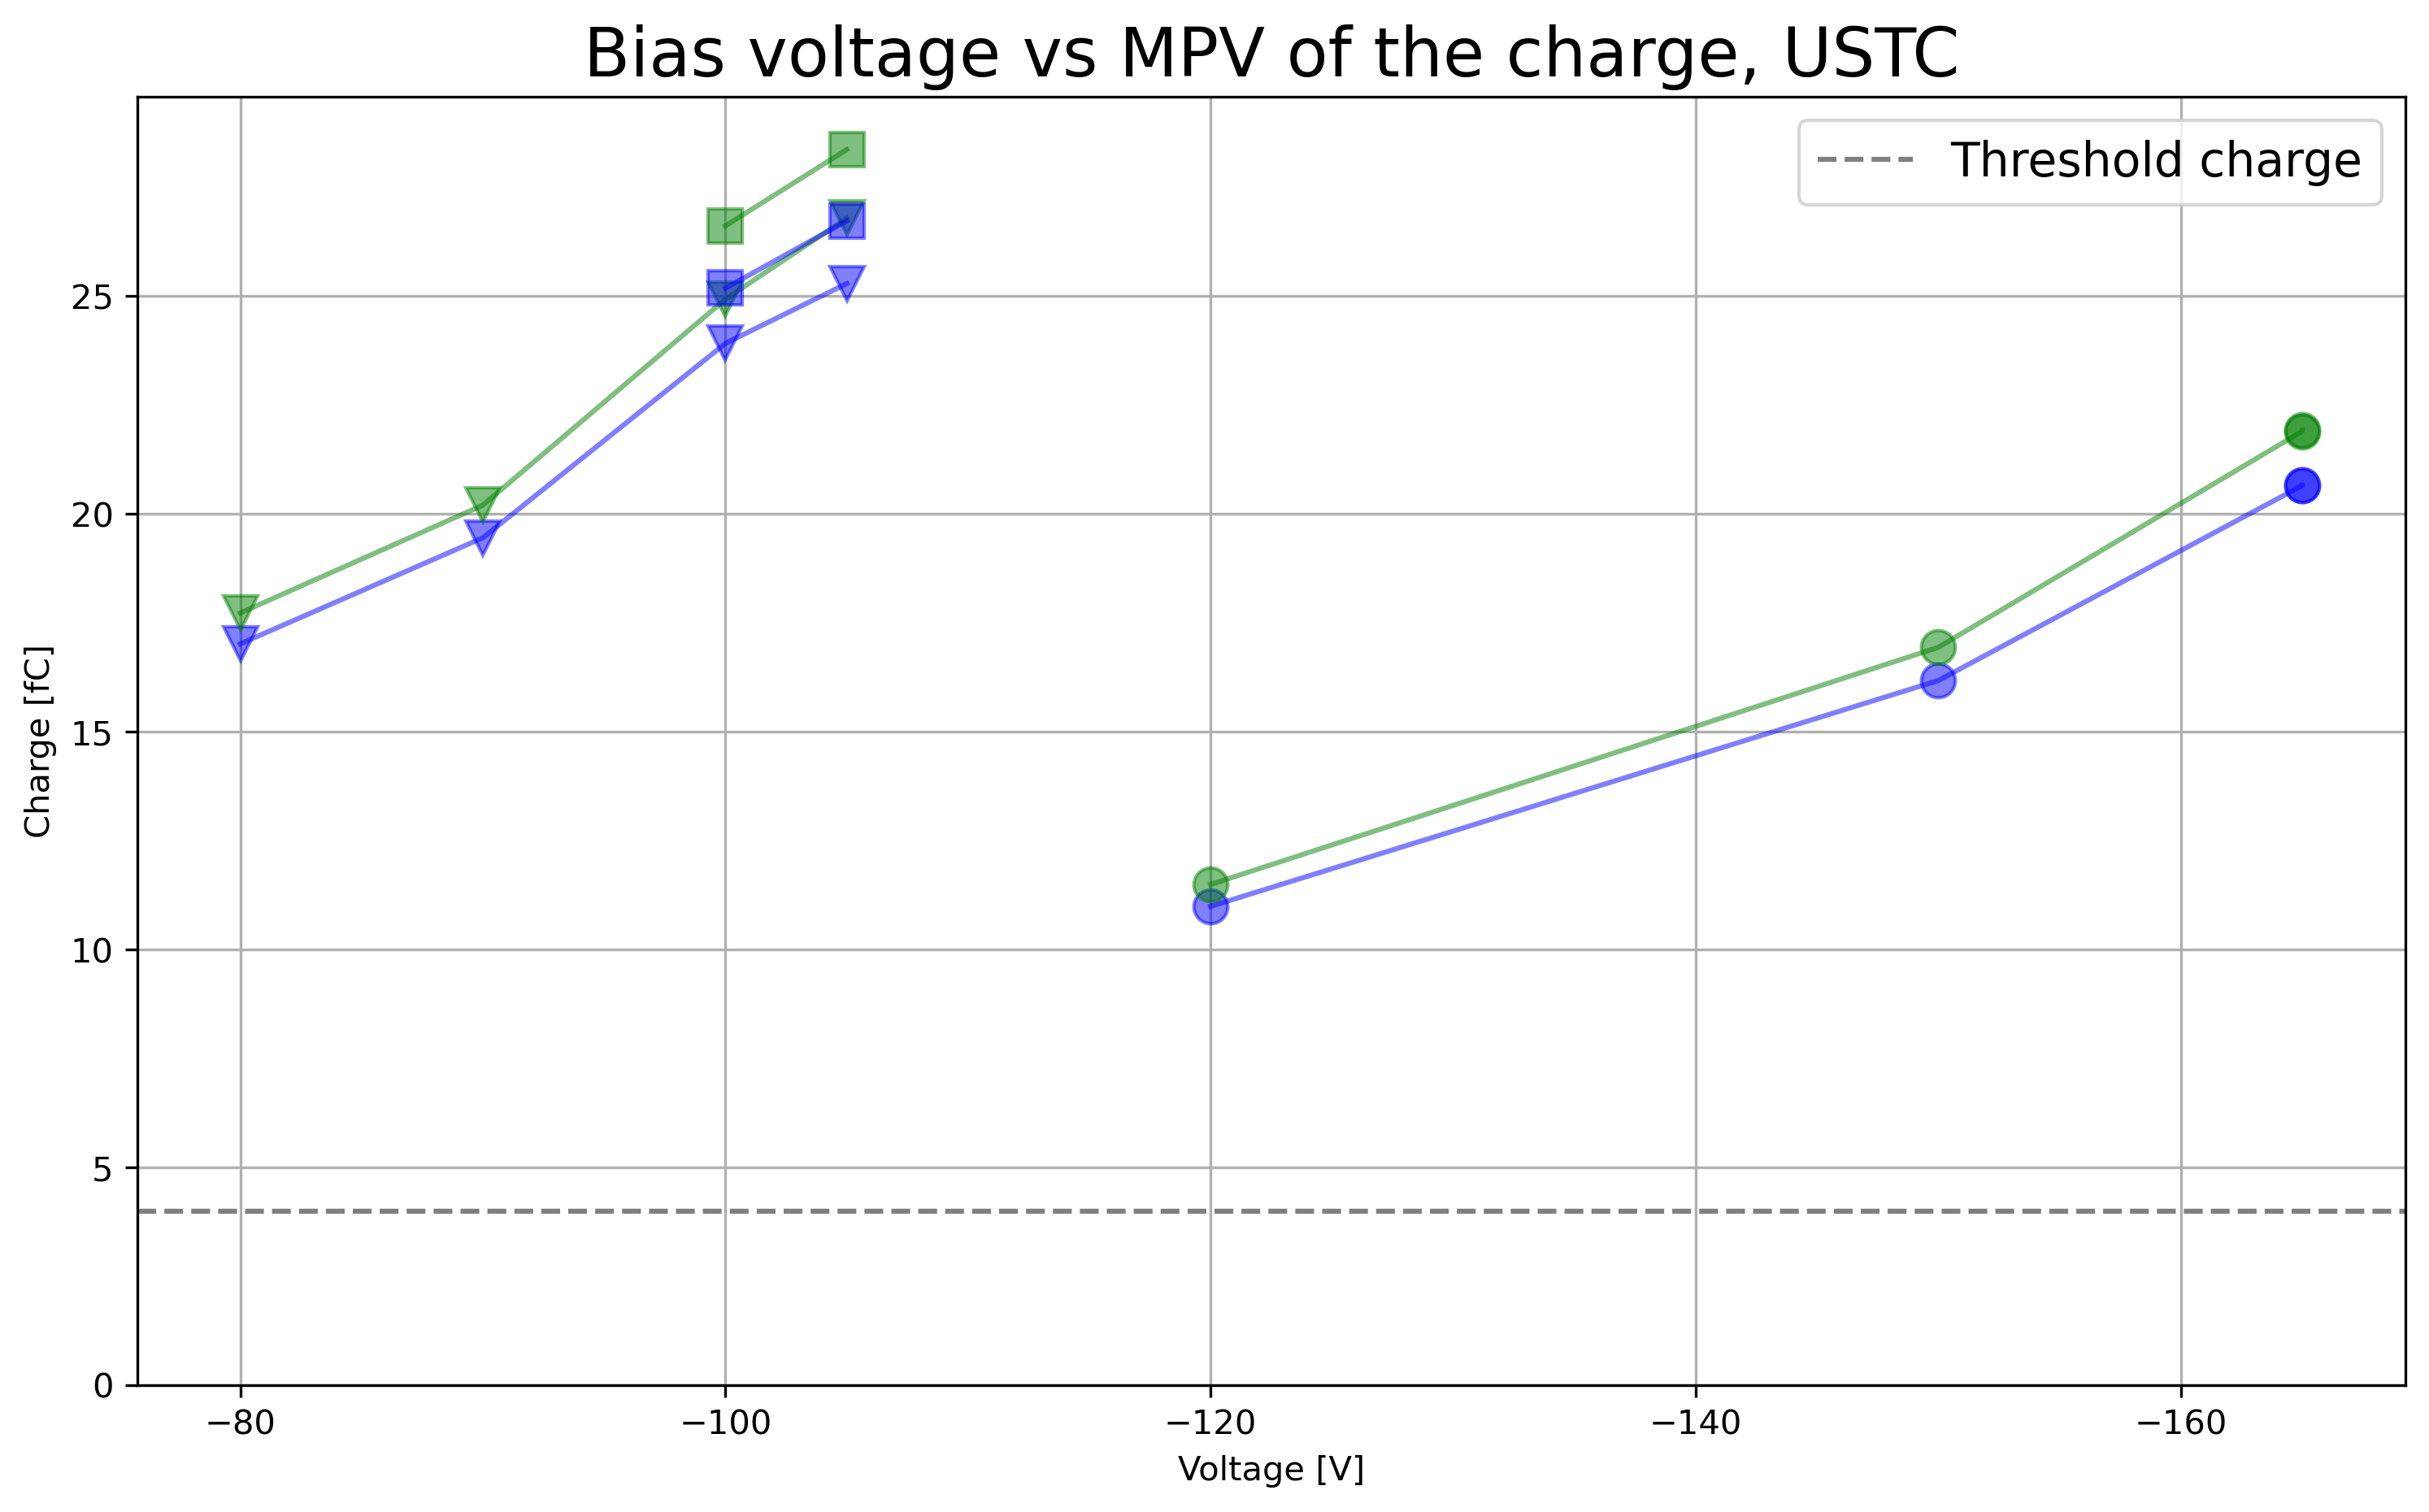

In [116]:
fig, ax = plt.subplots(figsize=(12,7), dpi=300)

list_of_texts = []
#     print(sensor_name)
for j,key in enumerate(['room_temp', 'normal', 'angled']):#, 'irradiated_2800']):#, 'angled', 'angled_irradiated']):
#         print(key)
    df_analysis = dict_analysis_USTC[key]
#     df_analysis = df_analysis.loc[df_analysis['exclude']==False]
#     df_analysis = df_analysis.loc[df_analysis['name']==sensor_name]

    for k,ch in enumerate(df_analysis.index.unique(2)):
        voltage = np.array(df_analysis.loc[idx[:,:,ch]]['voltage'])
        charge = np.array(df_analysis.loc[idx[:,:,ch]]['charge'])
        batch_labels = np.array(df_analysis.loc[:,:,ch].index.get_level_values('batch'))

        ax.plot(voltage, charge,
                marker=markers[j], markersize=10, alpha=0.5, color=colormap[1+k])  ### colors are fucked up
#                     label=f"{sensor_name}, {key}")
#                 label=f"{sensor_name}, {ch}")
#             for x,y,label in zip(voltage,charge,batch_labels):
#                 list_of_texts.append(ax.text(x, y, label))
ax.axhline(threshold_charge, linestyle='--', color='grey', label="Threshold charge")

ax.set_title(f"Bias voltage vs MPV of the charge, USTC", fontsize=20)
ax.set_xlabel("Voltage [V]")
ax.set_ylabel("Charge [fC]")
ax.set_ylim(0,None)
ax.invert_xaxis()

ax.grid('--')
ax.legend(fontsize=14)

adjust_text(list_of_texts)

# if SAVE:
#     fig.savefig(f"../various plots/{this_sensor}/USTC_plots_together_voltage_charge.svg", bbox_inches='tight')

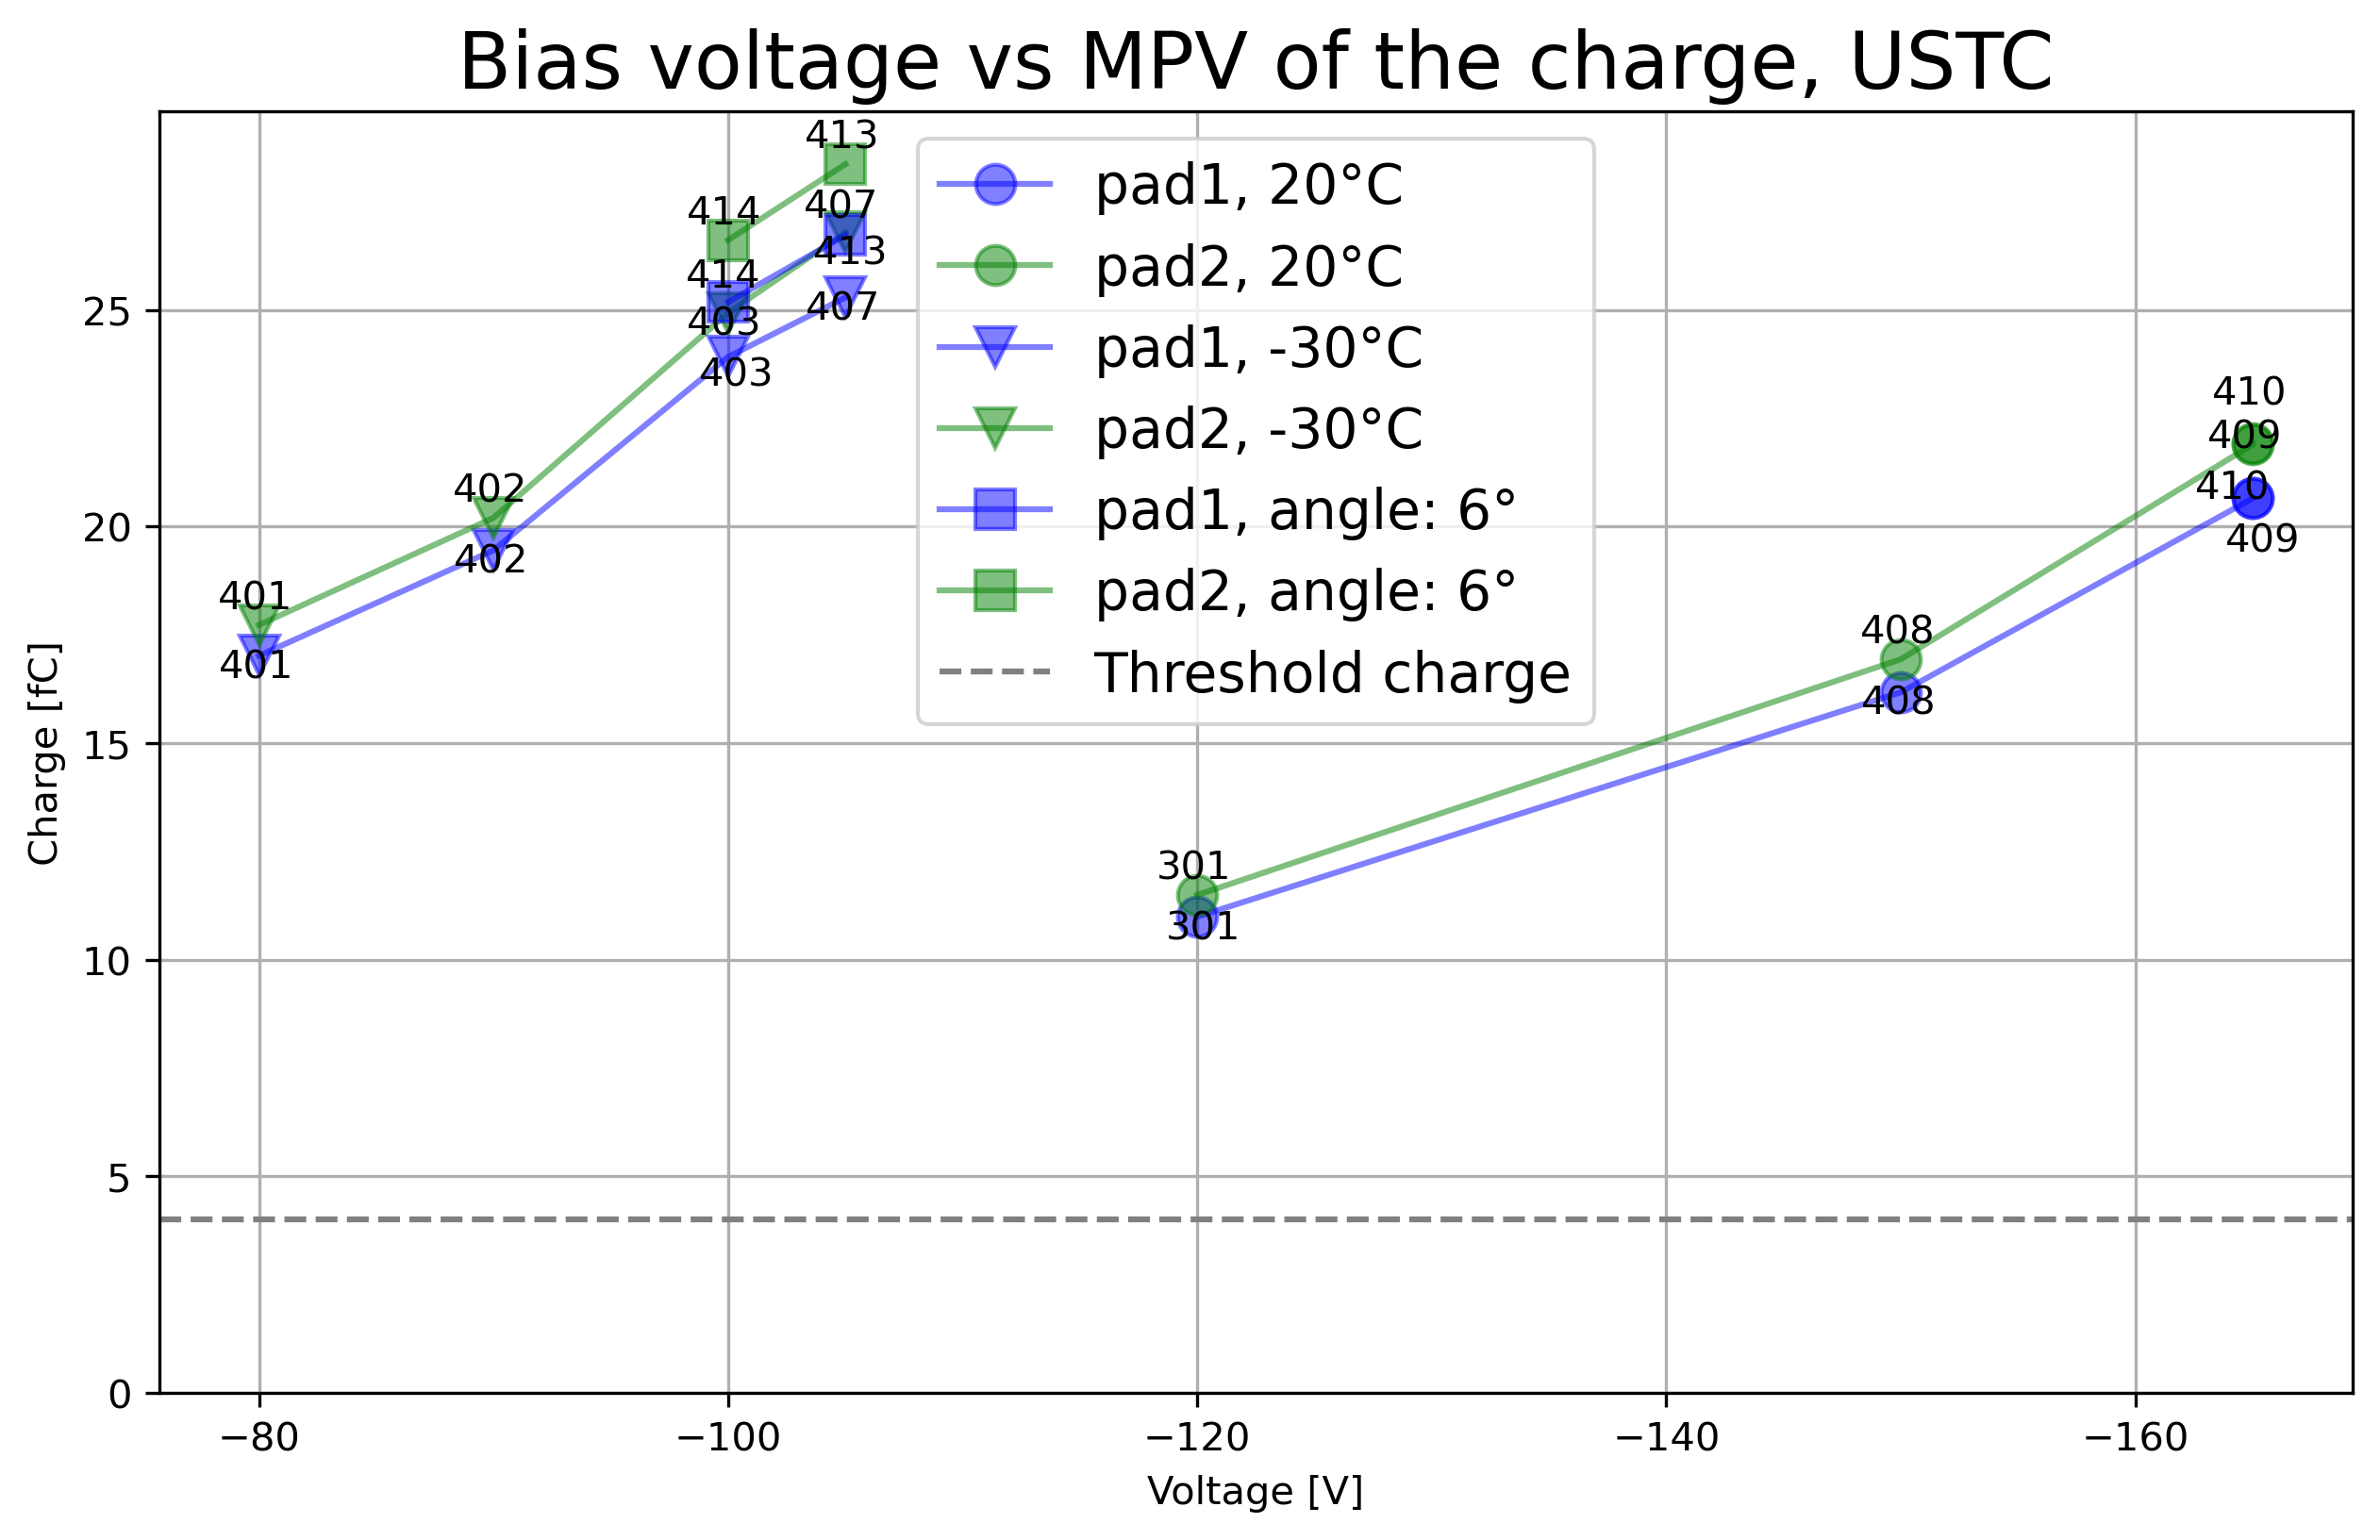

In [117]:
### CHARGE

fig, ax = plt.subplots(figsize=(10,6), dpi=300)

labels = ['20°C','-30°C','angle: 6°']
dut_labels = ["pad1", "pad2"]

list_of_texts = []
for j,key in enumerate(['room_temp', 'normal','angled']):
    df_analysis = dict_analysis_USTC[key]
    for i,ch in enumerate(['Ch2','Ch3']):
        voltage = np.array(df_analysis.loc[idx[:,:,ch]]['voltage'])
        charge = np.array(df_analysis.loc[idx[:,:,ch]]['charge'])
        batch_labels = np.array(df_analysis.loc[idx[:,:,ch]].index.get_level_values('batch'))

        ax.plot(voltage, charge,
            marker=markers[j], markersize=10, alpha=0.5, color=colormap[i+1],
            label=f"{dut_labels[i]}, {labels[j]}")
        for x,y,label in zip(voltage,charge,batch_labels):
            list_of_texts.append(ax.text(x, y, label))
            
        
ax.axhline(threshold_charge, linestyle='--', color='grey', label="Threshold charge")

ax.set_title(f"Bias voltage vs MPV of the charge, USTC", fontsize=20)
ax.set_xlabel("Voltage [V]")
ax.set_ylabel("Charge [fC]")
ax.set_ylim(0,None)
ax.invert_xaxis()

ax.grid('--')
ax.legend(fontsize=14)

adjust_text(list_of_texts)

# if SAVE:
#     fig.savefig(f"../various plots/{this_sensor}/USTC_plots_together_voltage_charge.svg", bbox_inches='tight')

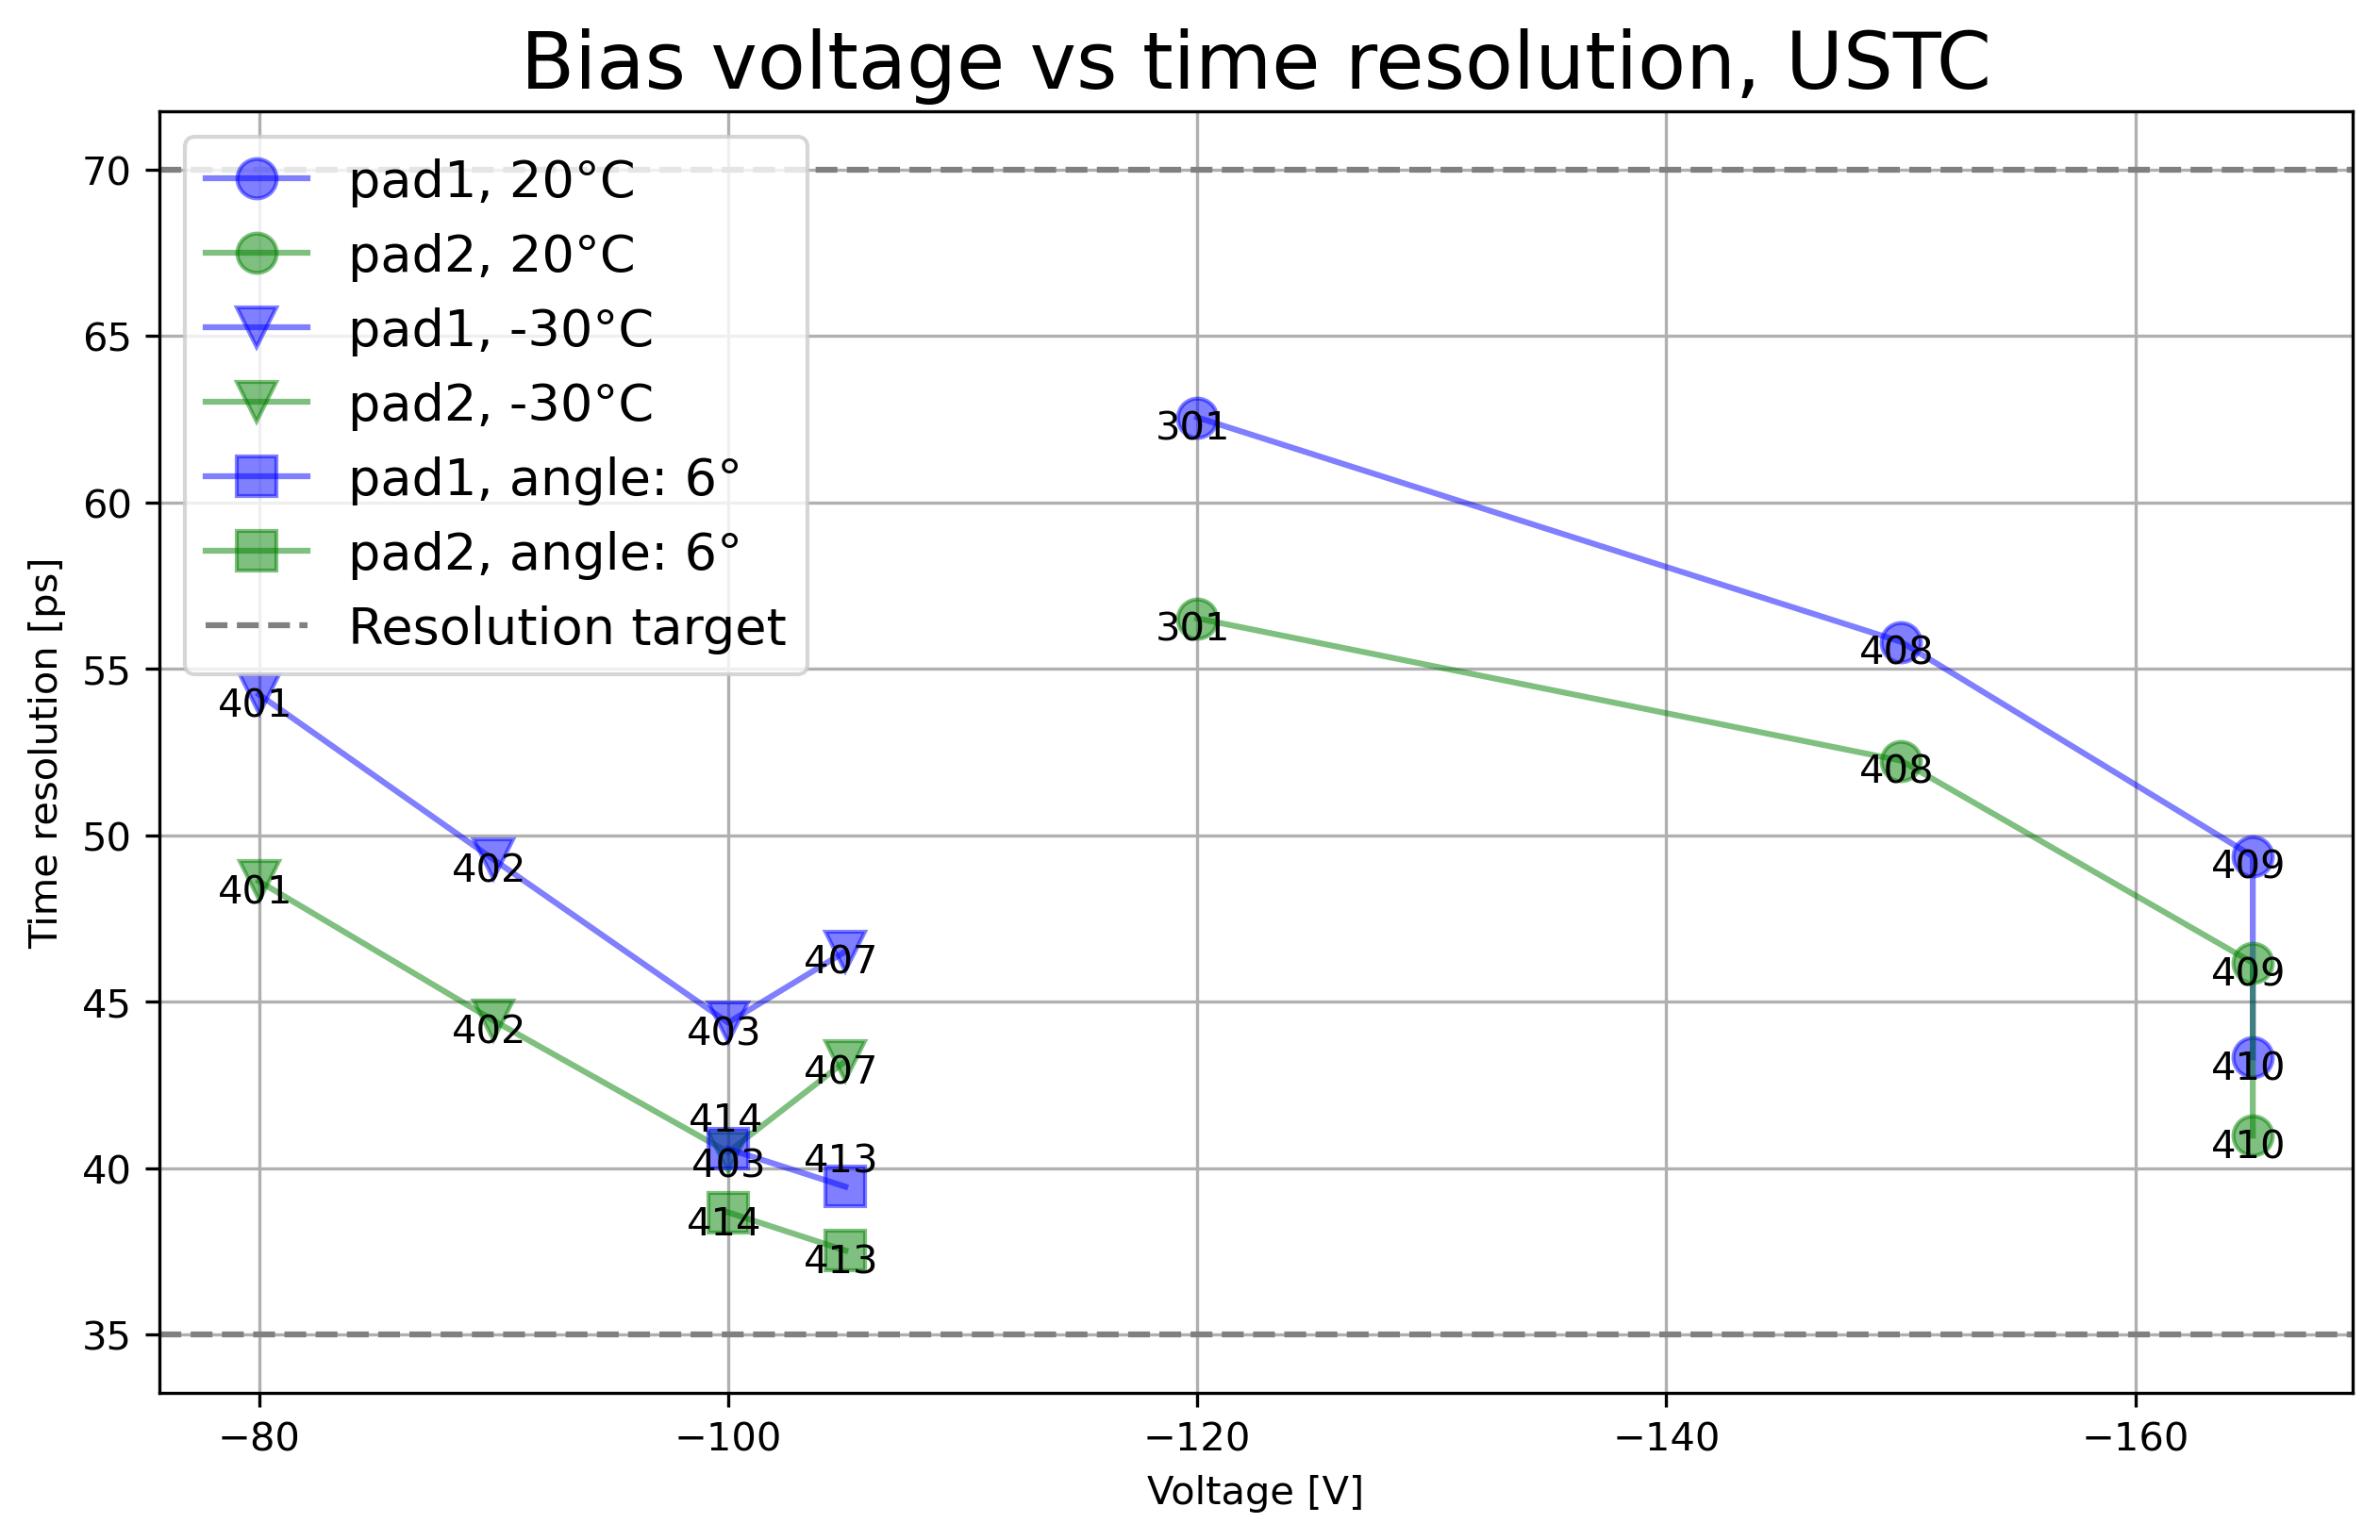

In [120]:
## TIME RESOLUTION

fig, ax = plt.subplots(figsize=(10,6), dpi=300)

# labels = ['room temperature', '-30°C','angle: 6° (MCP:2800V)']
list_of_texts = []
for j,key in enumerate(['room_temp', 'normal','angled']):
    df_analysis = dict_analysis_USTC[key]
    for i,ch in enumerate(['Ch2','Ch3']):
        voltage = np.array(df_analysis.loc[idx[:,:,ch]]['voltage'])
        time = np.array(df_analysis.loc[idx[:,:,ch]]['time_resolution'])
        batch_labels = np.array(df_analysis.loc[idx[:,:,ch]].index.get_level_values('batch'))

        ax.plot(voltage, time,
            marker=markers[j], markersize=10, alpha=0.5, color=colormap[i+1],
            label=f"{dut_labels[i]}, {labels[j]}")
        for x,y,label in zip(voltage,time,batch_labels):
            list_of_texts.append(ax.text(x, y, label))
            
ax.axhline(35, linestyle='--', color='grey', label="Resolution target")
ax.axhline(70, linestyle='--', color='grey')

ax.set_title(f"Bias voltage vs time resolution, USTC", fontsize=20)
ax.set_xlabel("Voltage [V]")
ax.set_ylabel("Time resolution [ps]")
# ax.set_ylim(30,75)
ax.invert_xaxis()

ax.grid('--')
ax.legend(fontsize=13)

adjust_text(list_of_texts)

# if SAVE:
#     fig.savefig(f"../various plots/{this_sensor}/USTC_plots_together_voltage_time_res.svg", bbox_inches='tight')


In [17]:
SAVE = True

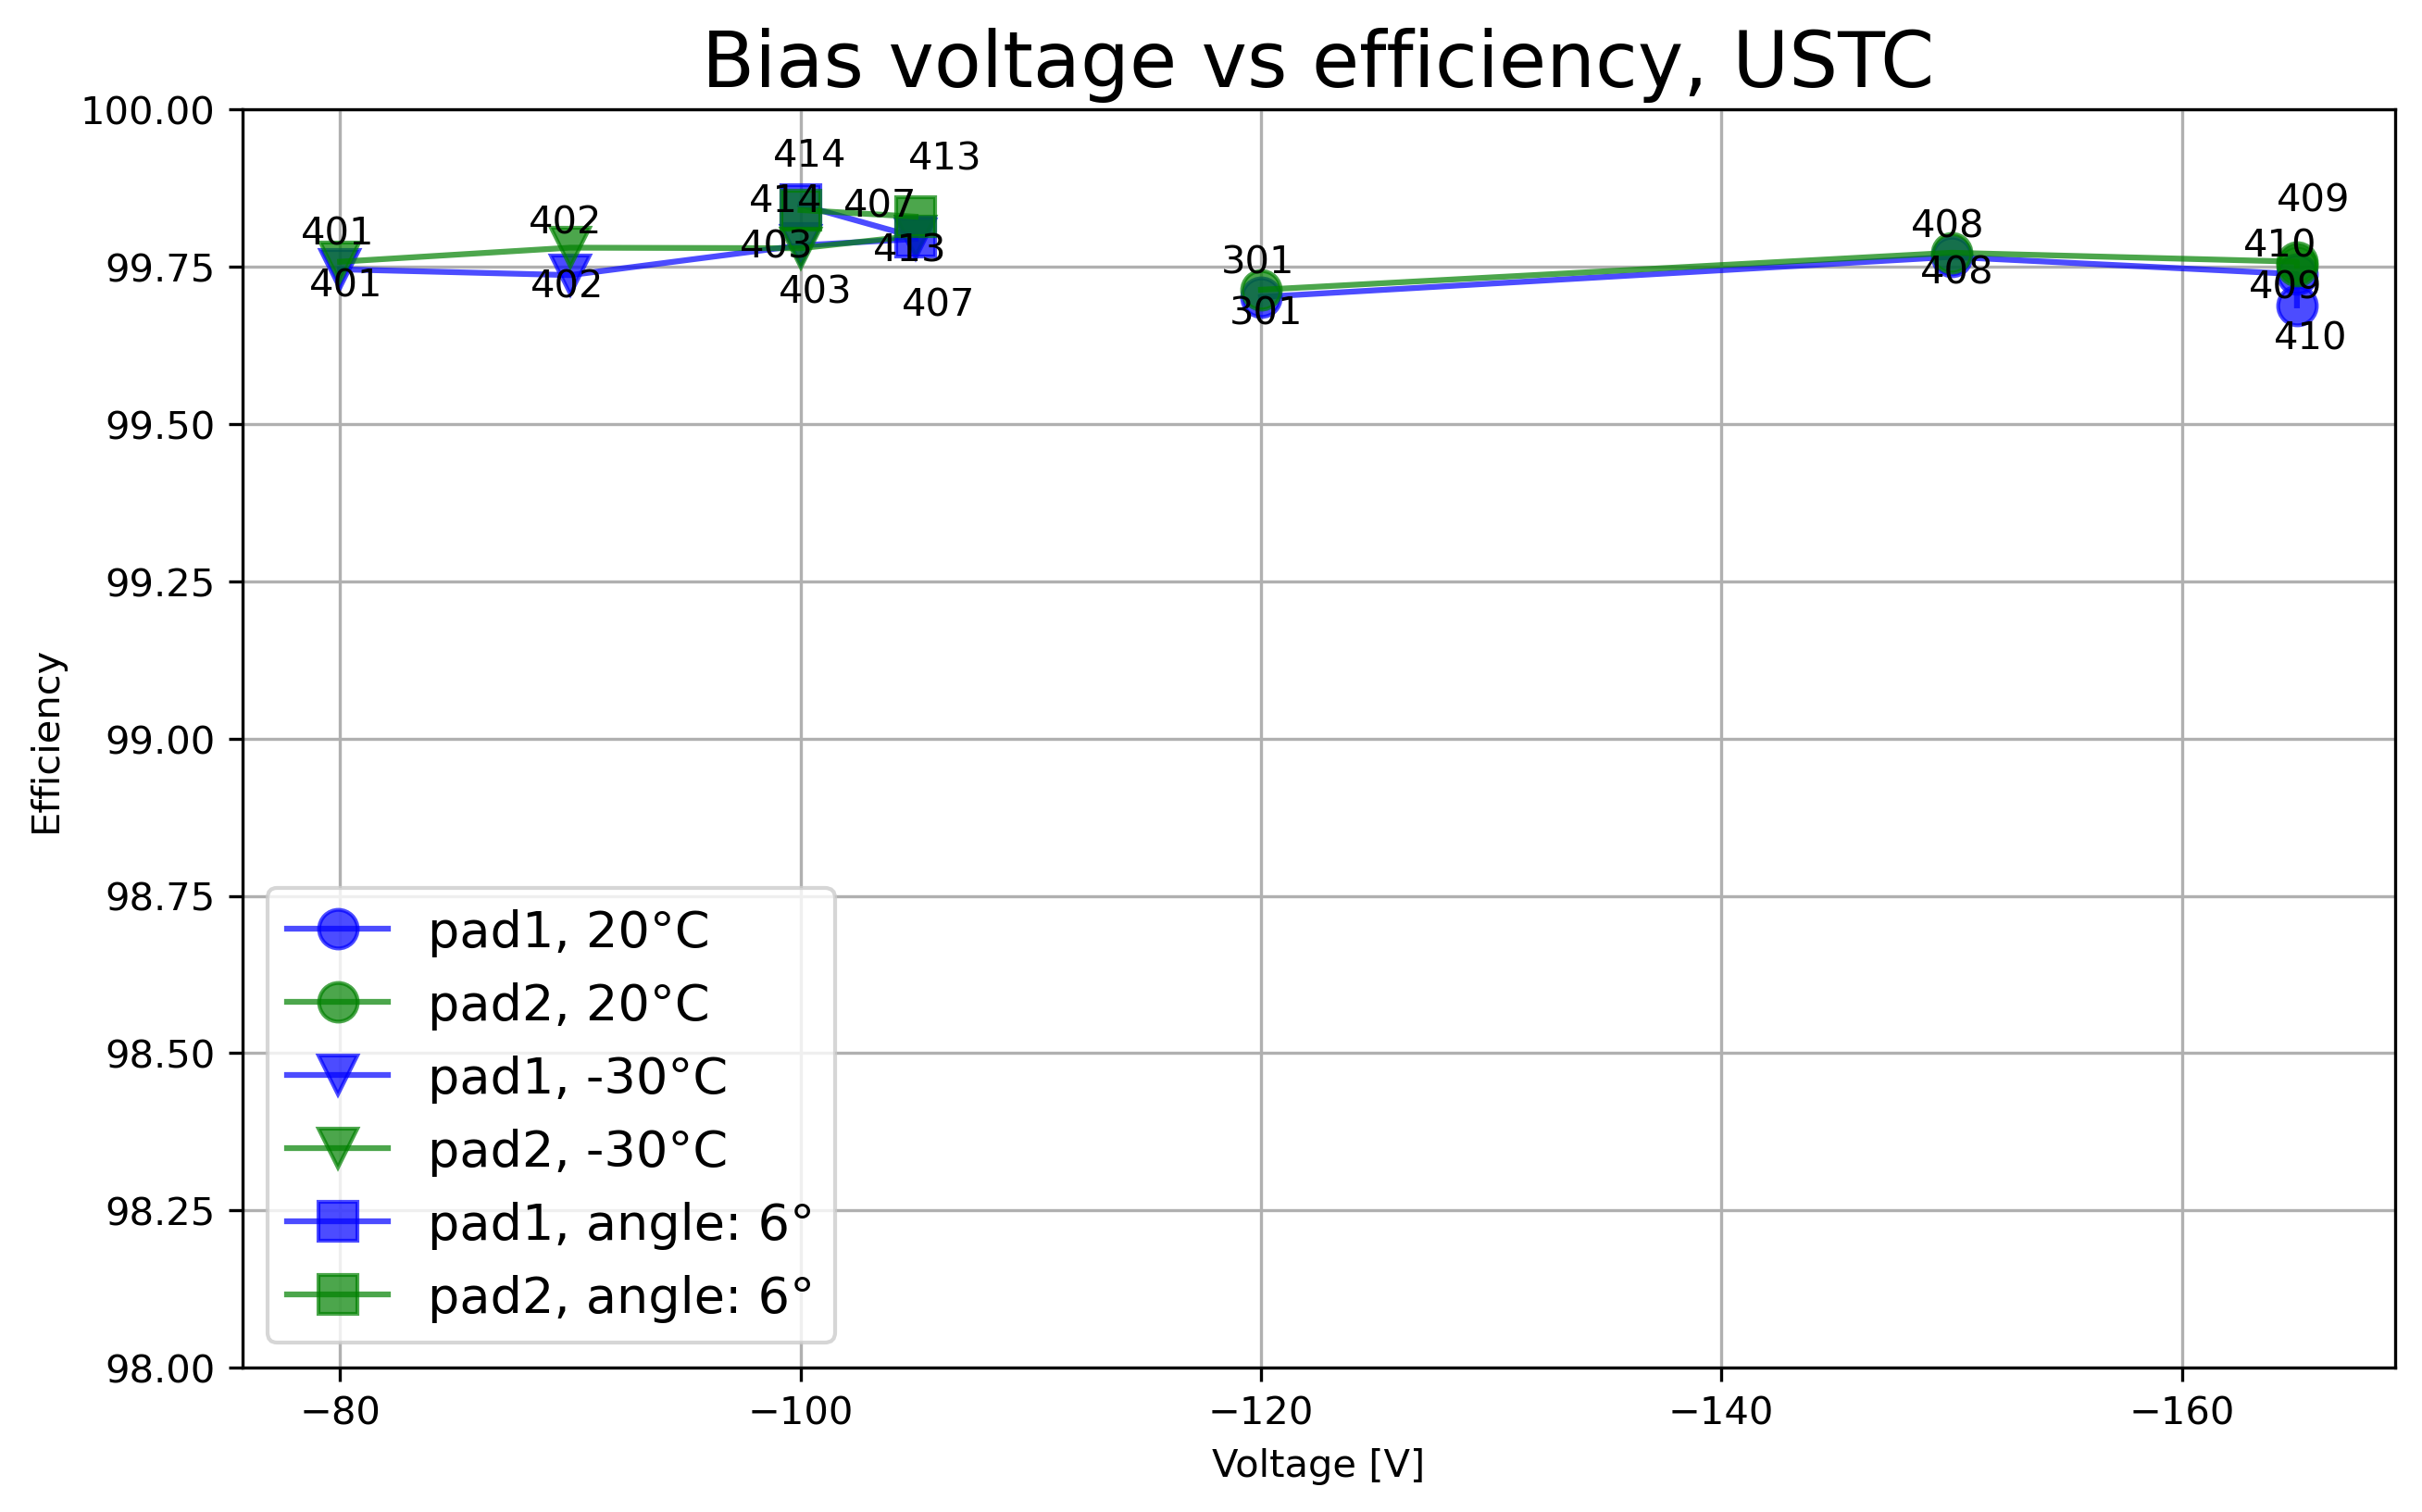

In [119]:
### EFFICIENCY

fig, ax = plt.subplots(figsize=(10,6), dpi=300)

# labels = ['room temperature', '-30°C','angle: 6° (MCP:2800V)']
list_of_texts = []
for j,key in enumerate(['room_temp', 'normal','angled']):
    df_analysis = dict_analysis_USTC[key]
    for i,ch in enumerate(['Ch2','Ch3']):
        voltage = np.array(df_analysis.loc[idx[:,:,ch]]['voltage'])
        eff = np.array(df_analysis.loc[idx[:,:,ch]]['efficiency'])
        batch_labels = np.array(df_analysis.loc[idx[:,:,ch]].index.get_level_values('batch'))

        ax.plot(voltage, eff,
            marker=markers[j], markersize=10, alpha=0.5, color=colormap[i+1],
            label=f"{dut_labels[i]}, {labels[j]}")
        for x,y,label in zip(voltage,eff,batch_labels):
            list_of_texts.append(ax.text(x, y, label))

# ax.axhline(35, linestyle='--', color='grey', label="Resolution target")
# ax.axhline(70, linestyle='--', color='grey')

ax.set_title(f"Bias voltage vs efficiency, USTC", fontsize=20)
ax.set_xlabel("Voltage [V]")
ax.set_ylabel("Efficiency")
ax.set_ylim(98,100)
ax.invert_xaxis()

ax.grid('--')
ax.legend(fontsize=13)

### this needs to be last
adjust_text(list_of_texts)

# if SAVE:
#     fig.savefig(f"../various plots/{this_sensor}/USTC_plots_together_voltage_efficiency.svg", bbox_inches='tight')


In [6]:
# def get_DUT_from_index(index_list):
#     """
#     Simple function to get a list of DUT numbers directly from the index, 
#     """
#     DUT_list = []
#     for ch in index_list:
#         match ch:
#             case 'Ch2' | 'ch2' | 'Ch_2' | 'ch_2': DUT_list.append(1)
#             case 'Ch3' | 'ch3' | 'Ch_3' | 'ch_3': DUT_list.append(2)
#             case 'Ch4' | 'ch4' | 'Ch_4' | 'ch_4': DUT_list.append(3)
#     return DUT_list

# CNM
looking specifically at one sensor

In [ ]:
this_sensor = 'CNM'
IME_names = set()
for name in unique_names:
    if this_sensor in name:
        print(name)
        IME_names.add(name)


Chi^2 formula:
$$
\chi^2 = \sum_i^N \frac{(E_i-O_i)^2}{E_i}\\
\chi^2_{reduced} = \frac{\chi^2}{N-d.o.f}
$$

In [1]:
fig,ax = plt.subplots(figsize=(20,12), dpi=300)
for batch, S, ch in dict_analysis_IME['angled'].index:
    print(batch,S,ch)
    df = load_batch(batch,S)
    match ch:
        case 'Ch2': dut = 1
        case 'Ch3': dut = 2
        case 'Ch4': dut = 3
    DUTs = [dut]
#     geo_cuts, geo_infos = zip(*[geometry_mask(df, DUT_number=dut, bins=large_bins, bins_find_min='rice', only_select='normal', use='pulseheight')
#                                 if dut in DUTs else (None,None) for dut in [1,2,3]])
    plot_histogram(df[f'charge_{dut}']/4700, bins=1000, fig_ax=(fig,ax), label=f"{batch}, {S}, {ch}")
ax.semilogy()
ax.set_xlim(-50,300)
ax.legend()

NameError: name 'plt' is not defined